### PSF Investigation

In [1]:
import pandas as pd                                                               
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
from astropy.table import Table
import lsst.afw.table as afwTable
savepre = '/home/dtaranu/raid/lsst/w2019_02_coaddpsf'
savepost = '.parq'
bands = ['HSC-' + x for x in ['G','R','I']]
files = {
    band: glob.glob('/datasets/hsc/repo/rerun/RC/w_2019_02/DM-16110/'
                    'deepCoadd-results/{}/*/*/meas*'.format(band))
    for band in bands
}
%matplotlib inline
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 240

In [2]:
def make_summary(file):
    try:
        src = afwTable.BaseCatalog.readFits(file)
    except:
        return None
    print(file)
    mask = np.logical_and.reduce((
        src.get('calib_psf_used')==1,
        src.get('base_PixelFlags_flag_interpolated')==False,
        src.get('base_PixelFlags_flag_saturated')==False,
        src.get('base_PixelFlags_flag_inexact_psf')==False,
        src.get('base_PixelFlags_flag_clipped')==False
    ))
    if np.sum(mask)==0:
        print('No data')
        return None
    sIxxKey = src.schema.find('base_SdssShape_xx').key
    sIyyKey = src.schema.find('base_SdssShape_yy').key
    sIxyKey = src.schema.find('base_SdssShape_xy').key
    mIxxKey = src.schema.find('base_SdssShape_psf_xx').key
    mIyyKey = src.schema.find('base_SdssShape_psf_yy').key
    mIxyKey = src.schema.find('base_SdssShape_psf_xy').key
    fluxPsfKey = src.schema.find('base_PsfFlux_instFlux').key
    fluxPsfErrKey = src.schema.find('base_PsfFlux_instFluxErr').key
    fluxCmodelKey = src.schema.find('modelfit_CModel_instFlux').key
    fluxCmodelErrKey = src.schema.find('modelfit_CModel_instFluxErr').key
    stars = src[mask]
    starIxx = src.get(sIxxKey)[mask]
    starIxy = src.get(sIxyKey)[mask]
    starIyy = src.get(sIyyKey)[mask]
    modelIxx = src.get(mIxxKey)[mask]
    modelIxy = src.get(mIxyKey)[mask]
    modelIyy = src.get(mIyyKey)[mask]
    data = {}
    data['starE1'] = (starIxx-starIyy)/(starIxx+starIyy)
    data['starE2'] = (2*starIxy)/(starIxx+starIyy)
    data['starSize'] = np.sqrt(0.5*(starIxx + starIyy))*2.354820045*0.168
    data['modelE1'] = (modelIxx-modelIyy)/(modelIxx+modelIyy)
    data['modelE2'] = (2*modelIxy)/(modelIxx+modelIyy)
    data['modelSize'] = np.sqrt(0.5*(modelIxx + modelIyy))*2.354820045*0.168
    data['ra'] = [a.getCoord().getRa().asDegrees() for a in stars]
    data['dec'] = [a.getCoord().getDec().asDegrees() for a in stars]
    data['fluxPsf'] = src.get(fluxPsfKey)[mask]
    data['fluxPsfErr'] = src.get(fluxPsfErrKey)[mask]
    data['fluxCmodel'] = src.get(fluxCmodelKey)[mask]
    data['fluxCmodelErr'] = src.get(fluxCmodelErrKey)[mask]
    data['file'] = file
    #data['visit'] = visit
    df = pd.DataFrame(data)
    return df

def make_parquet(filesin, fileout):
    data=[]
    for f in filesin:
        result = make_summary(f)
        if result is None:
            continue
        data.append(result)
    warp = pd.concat(data)
    warp.to_parquet(fileout)
    return warp

In [3]:
data = {}
for band in bands:
    savefile = ('_' + band).join([savepre, savepost])
    print(savefile)
    if not os.path.exists(savefile):
        data[band] = make_parquet(files[band], savefile)
    else:
        data[band] = pd.read_parquet(savefile)

/home/dtaranu/raid/lsst/w2019_02_coaddpsf_HSC-G.parq
/home/dtaranu/raid/lsst/w2019_02_coaddpsf_HSC-R.parq
/home/dtaranu/raid/lsst/w2019_02_coaddpsf_HSC-I.parq


/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


HSC-G, 0.521 <= starSize <= 0.621, N=2843
HSC-G, 0.621 <= starSize <= 0.637, N=2843
HSC-G, 0.637 <= starSize <= 0.648, N=2843
HSC-G, 0.648 <= starSize <= 0.656, N=2843
HSC-G, 0.656 <= starSize <= 0.667, N=2843
HSC-G, 0.667 <= starSize <= 0.695, N=2844
HSC-G, 0.695 <= starSize <= 0.768, N=2843
HSC-G, 0.768 <= starSize <= 0.802, N=2843
HSC-G, 0.802 <= starSize <= 0.844, N=2843
HSC-G, 0.844 <= starSize <= 29.156, N=2843
HSC-R, 0.393 <= starSize <= 0.458, N=4338
HSC-R, 0.458 <= starSize <= 0.469, N=4338
HSC-R, 0.469 <= starSize <= 0.478, N=4338
HSC-R, 0.478 <= starSize <= 0.486, N=4338
HSC-R, 0.486 <= starSize <= 0.496, N=4337
HSC-R, 0.496 <= starSize <= 0.520, N=4338
HSC-R, 0.520 <= starSize <= 0.573, N=4338
HSC-R, 0.573 <= starSize <= 0.600, N=4338
HSC-R, 0.600 <= starSize <= 0.624, N=4338
HSC-R, 0.624 <= starSize <= 26.642, N=4338
HSC-I, 0.386 <= starSize <= 0.456, N=3727


/home/dtaranu/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HSC-I, 0.456 <= starSize <= 0.465, N=3727
HSC-I, 0.465 <= starSize <= 0.476, N=3727
HSC-I, 0.476 <= starSize <= 0.493, N=3727
HSC-I, 0.493 <= starSize <= 0.509, N=3727
HSC-I, 0.509 <= starSize <= 0.525, N=3727
HSC-I, 0.525 <= starSize <= 0.537, N=3727
HSC-I, 0.537 <= starSize <= 0.549, N=3727
HSC-I, 0.549 <= starSize <= 0.574, N=3727
HSC-I, 0.574 <= starSize <= 26.479, N=3726


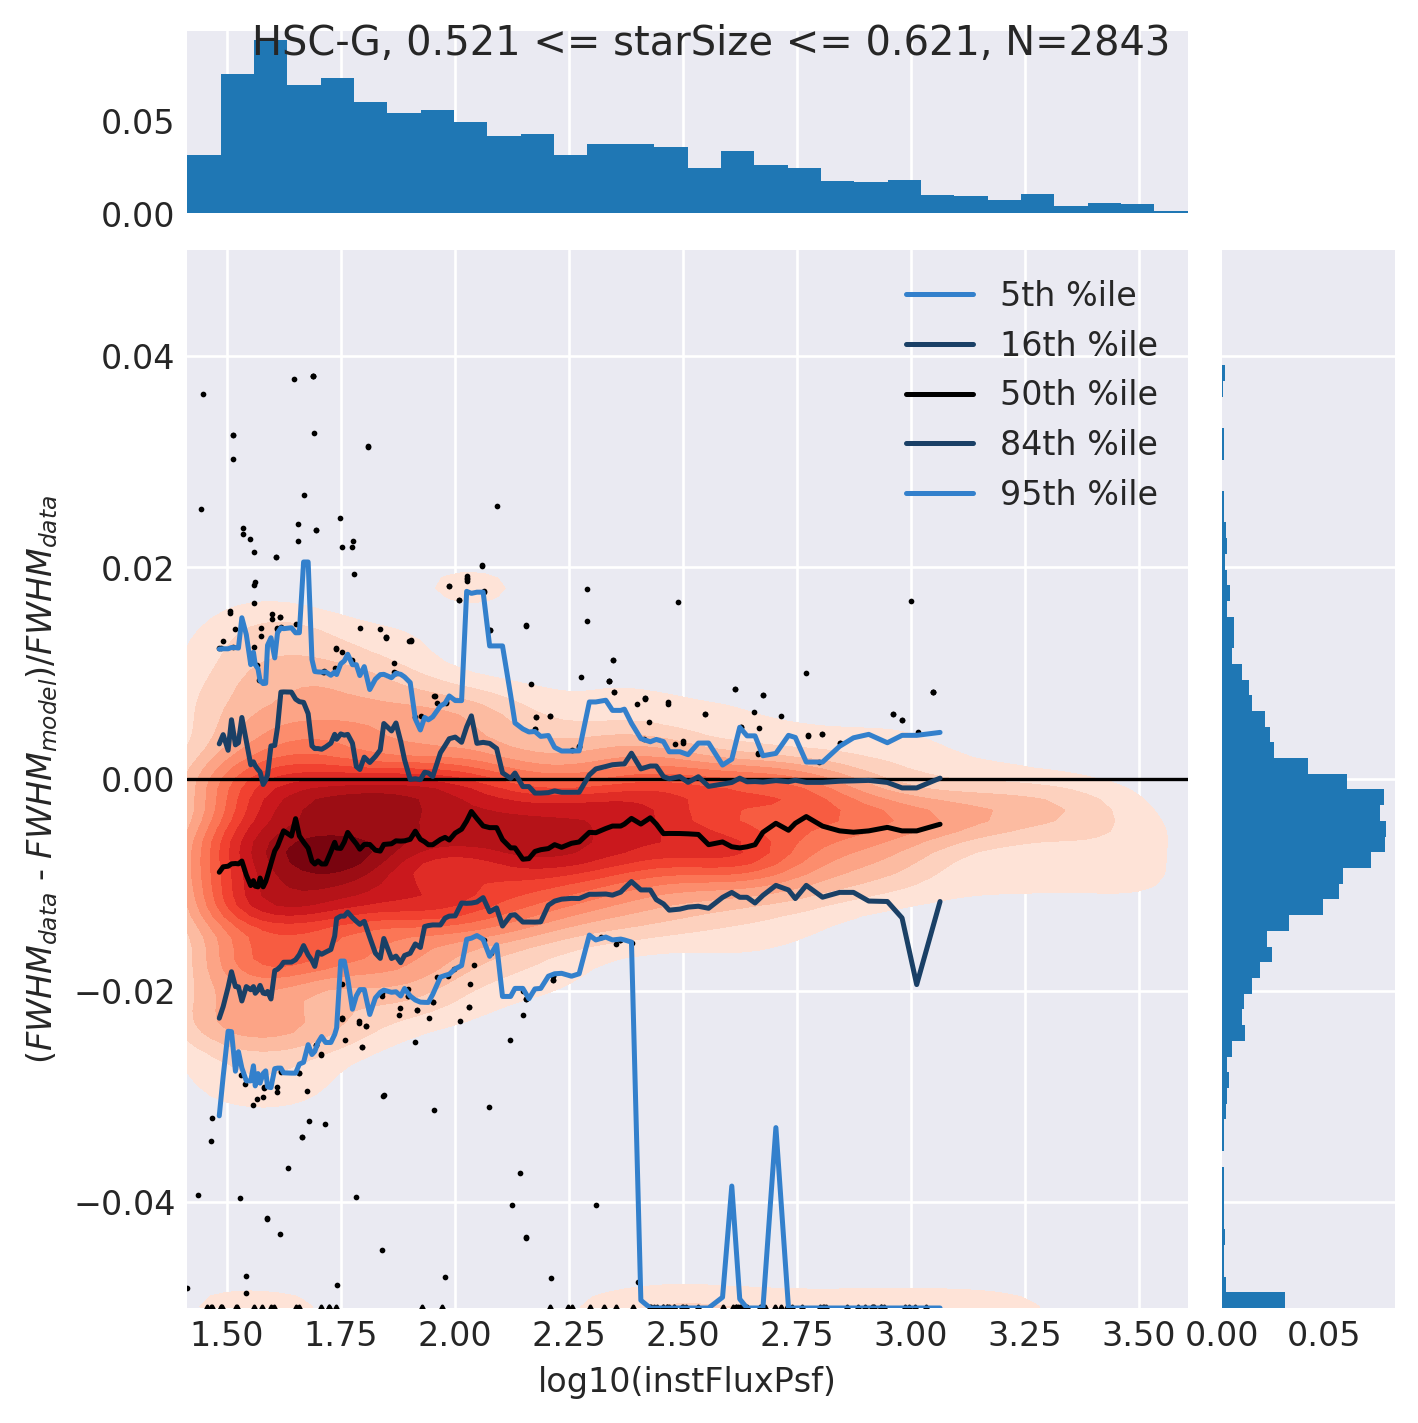

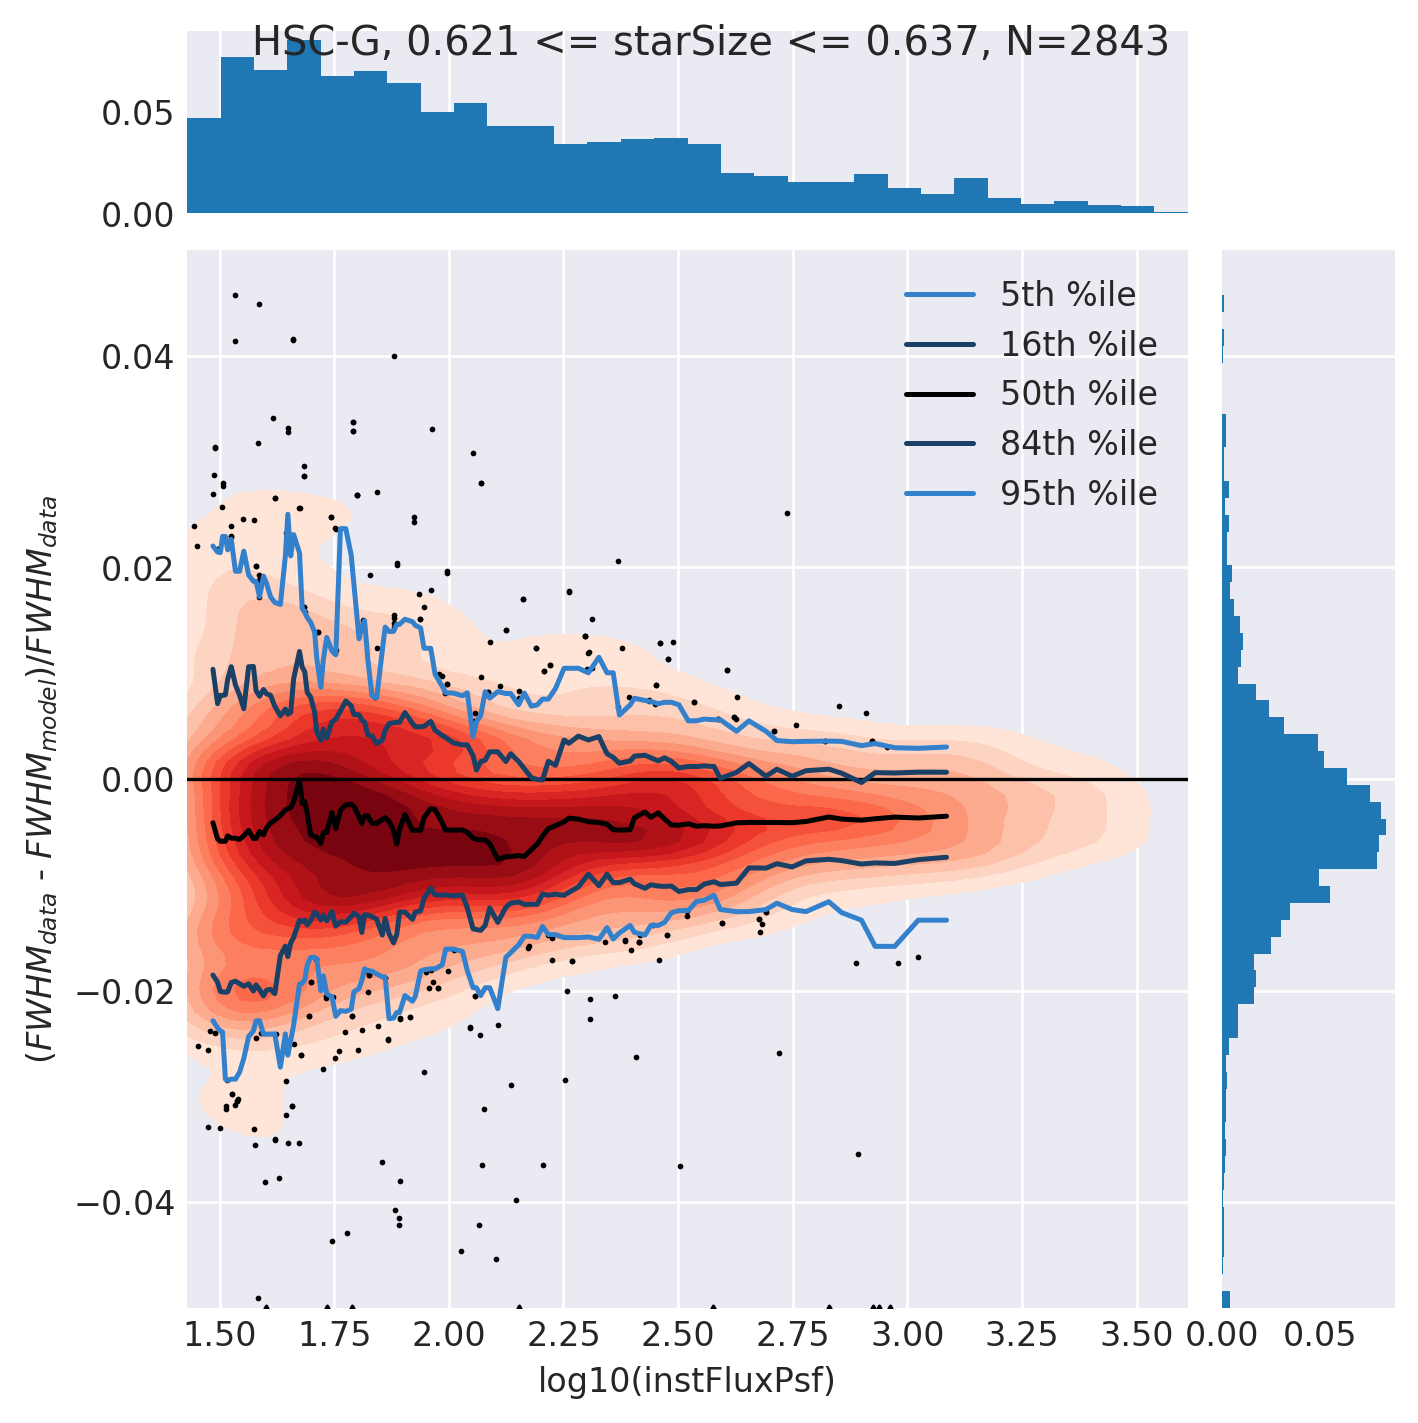

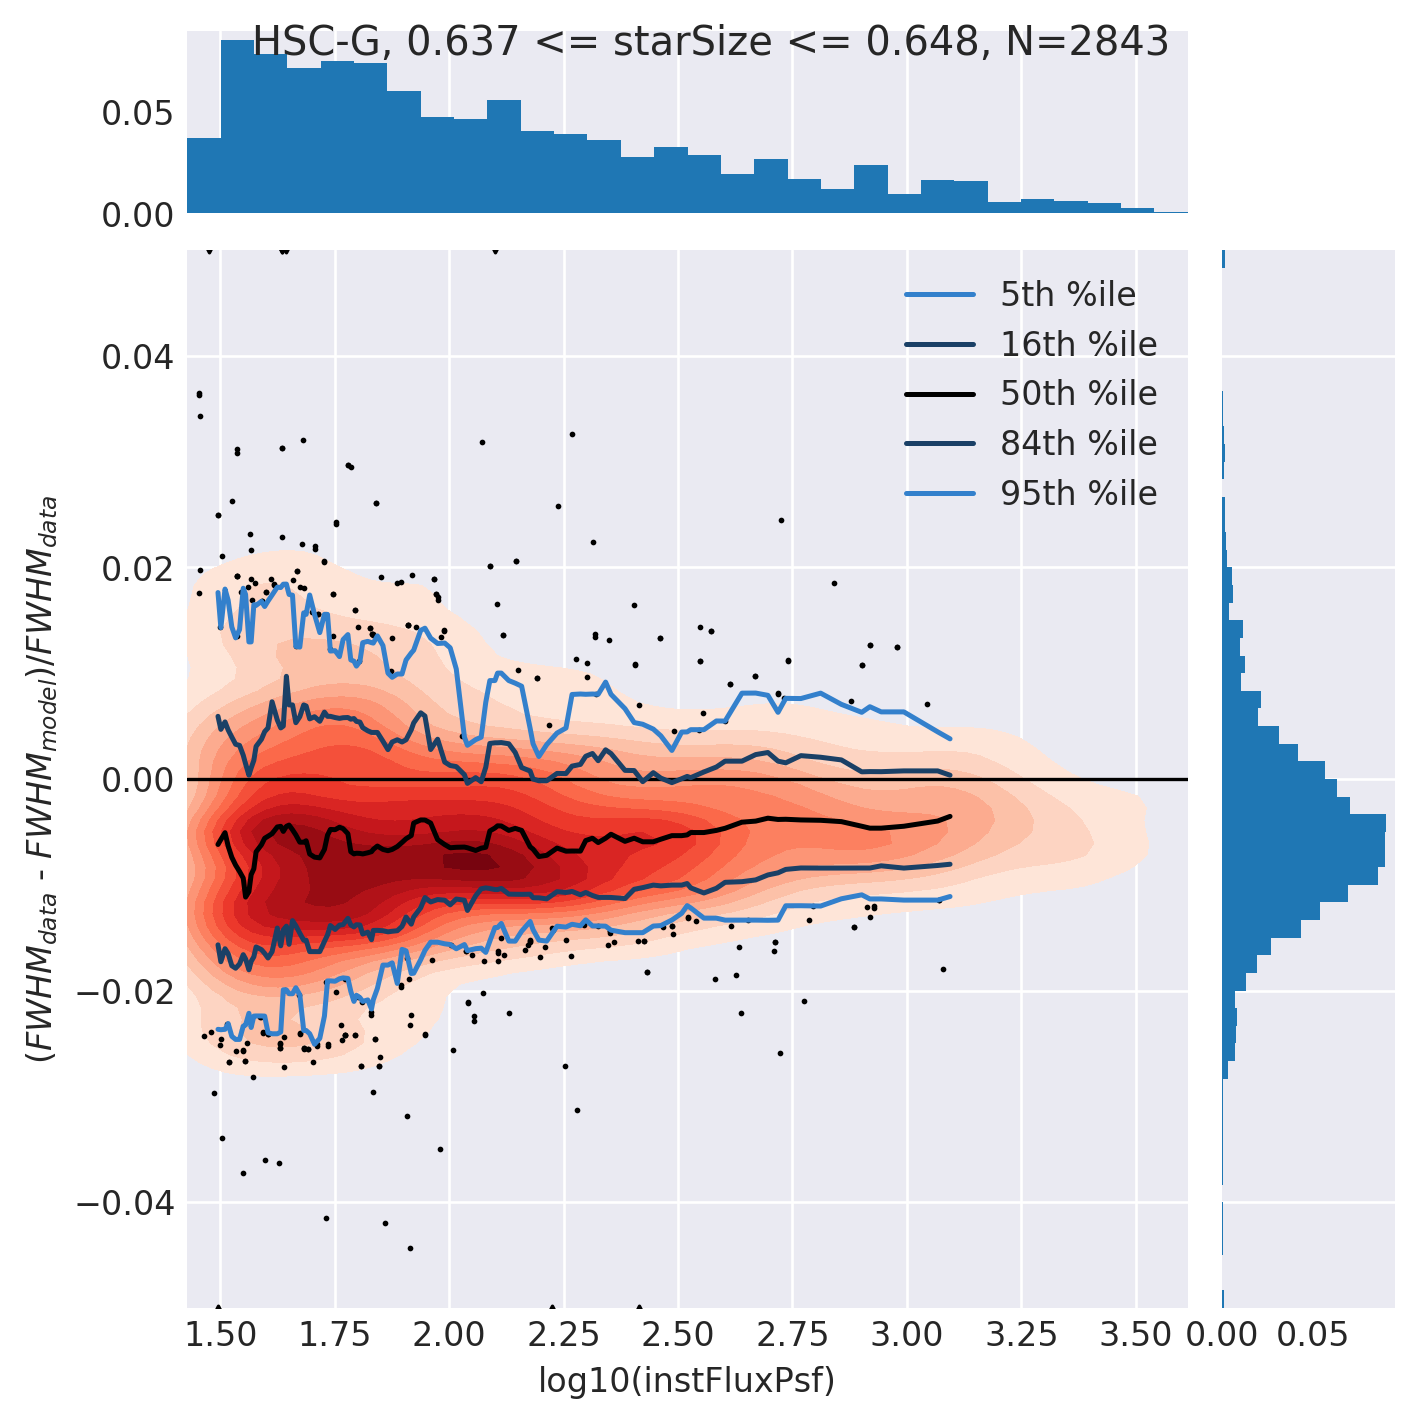

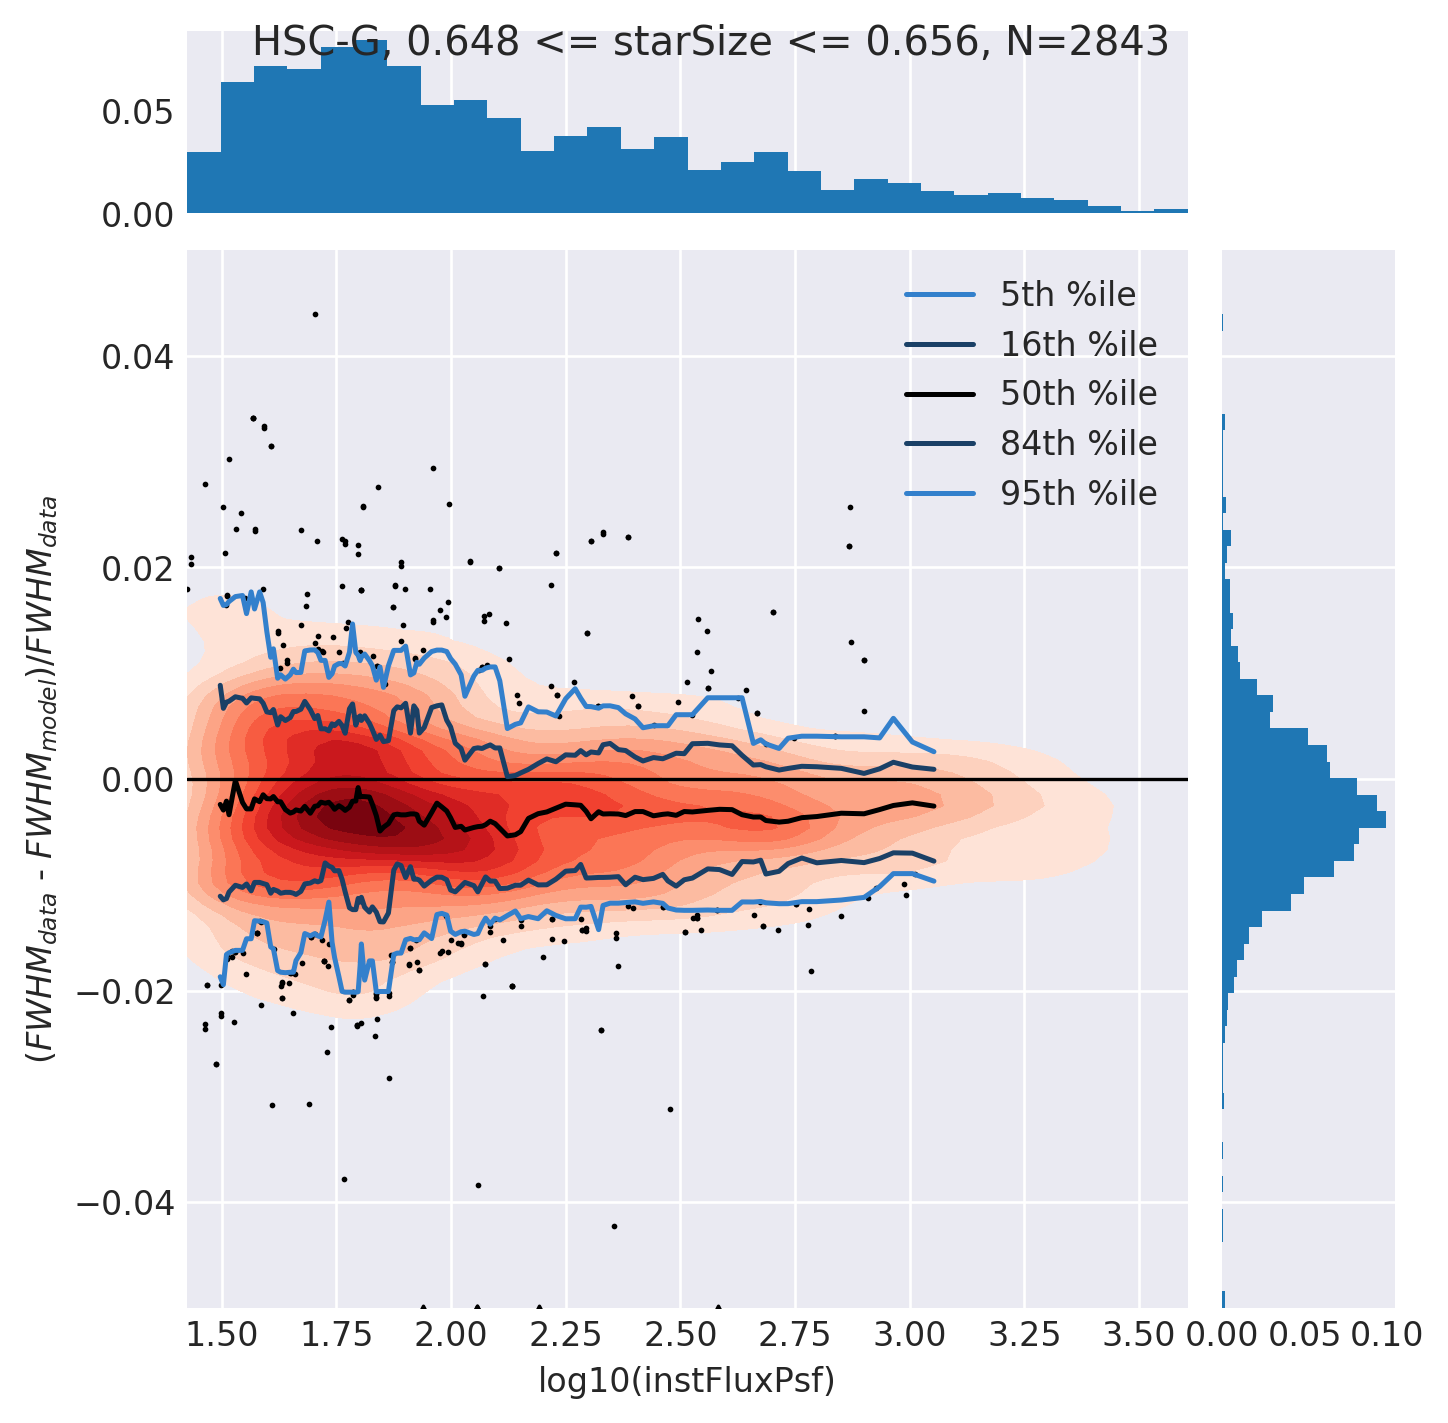

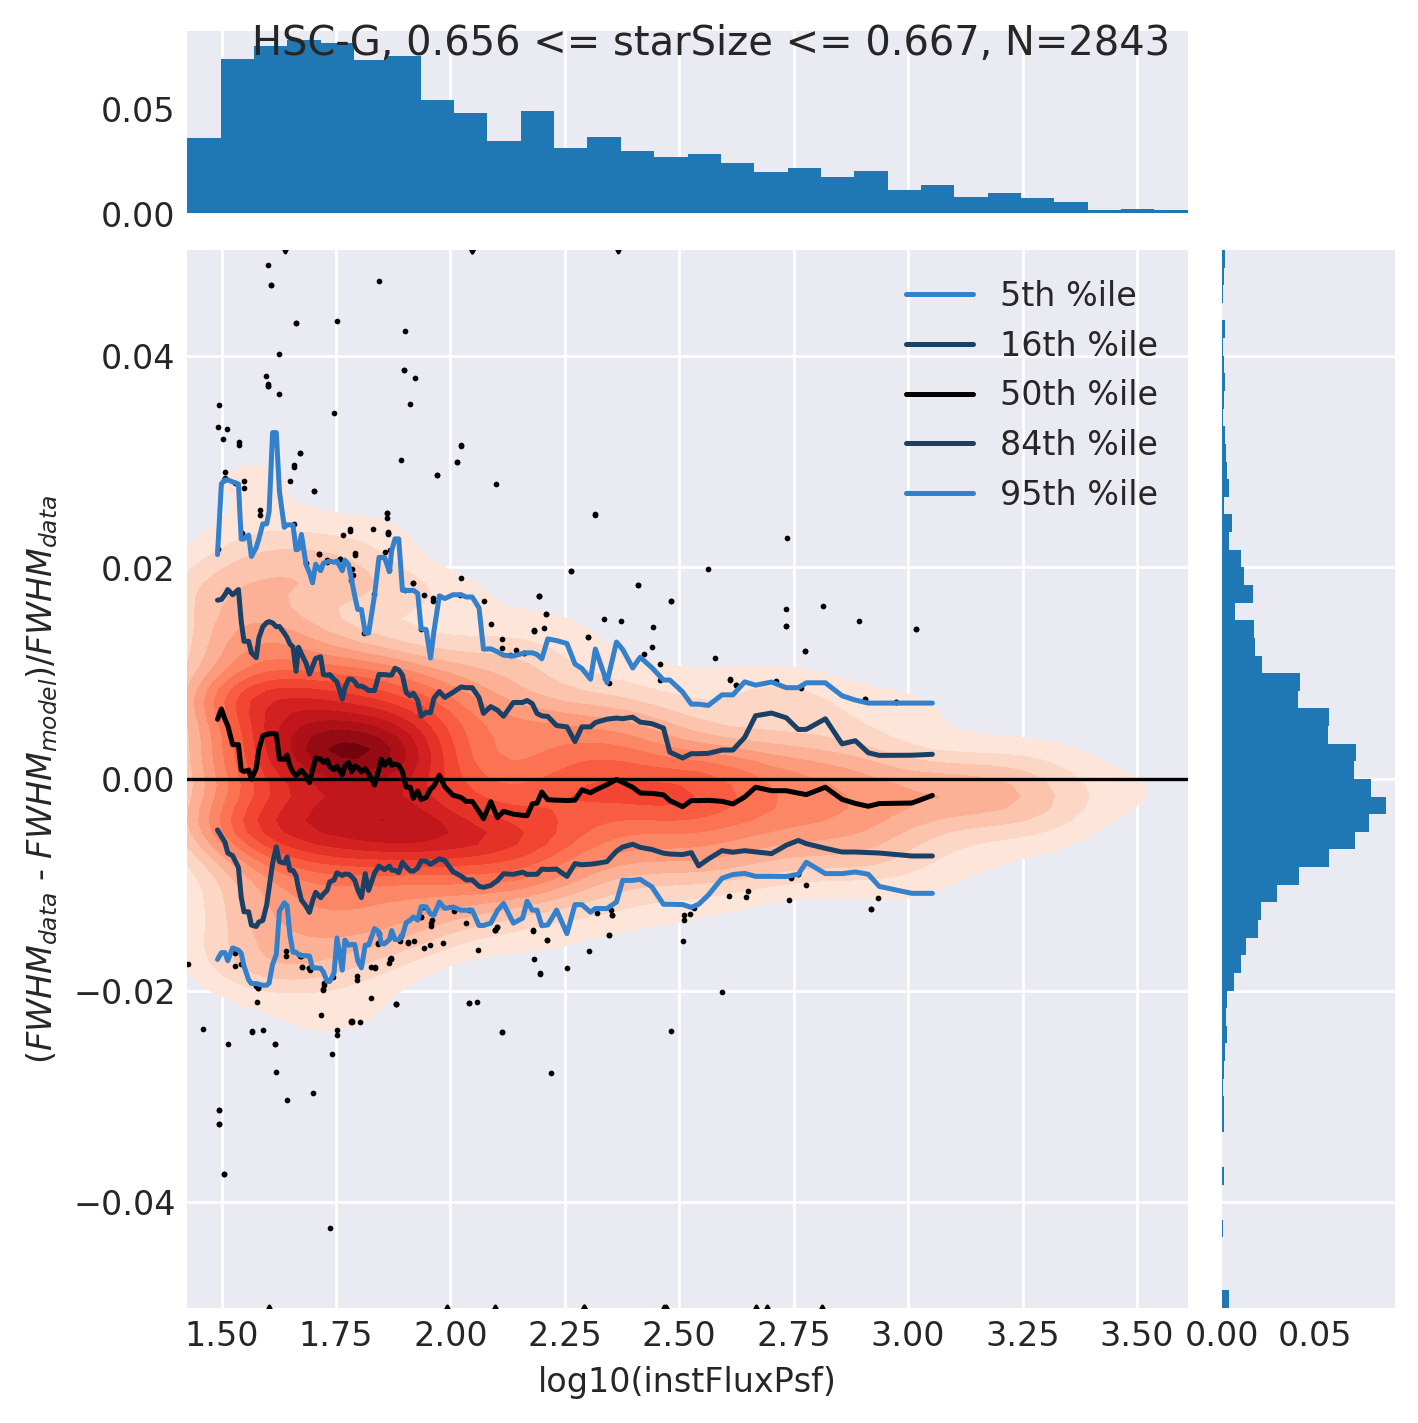

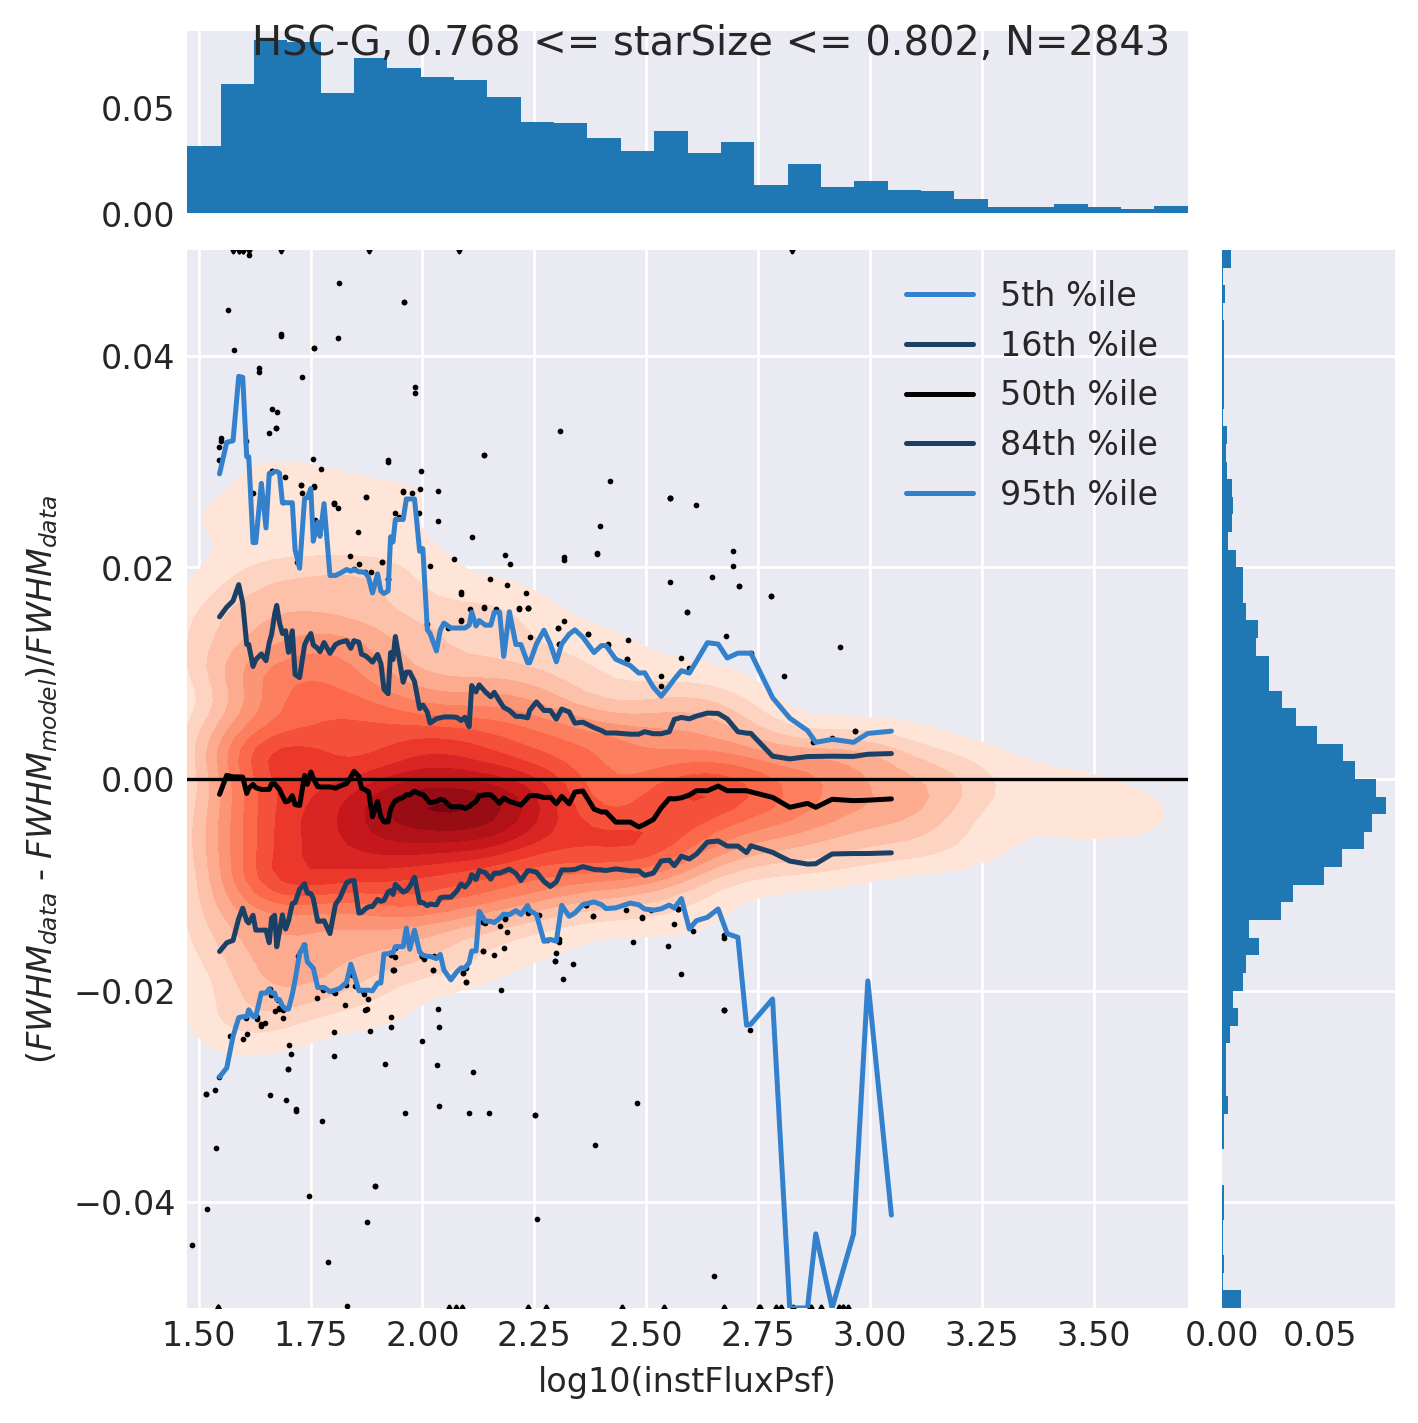

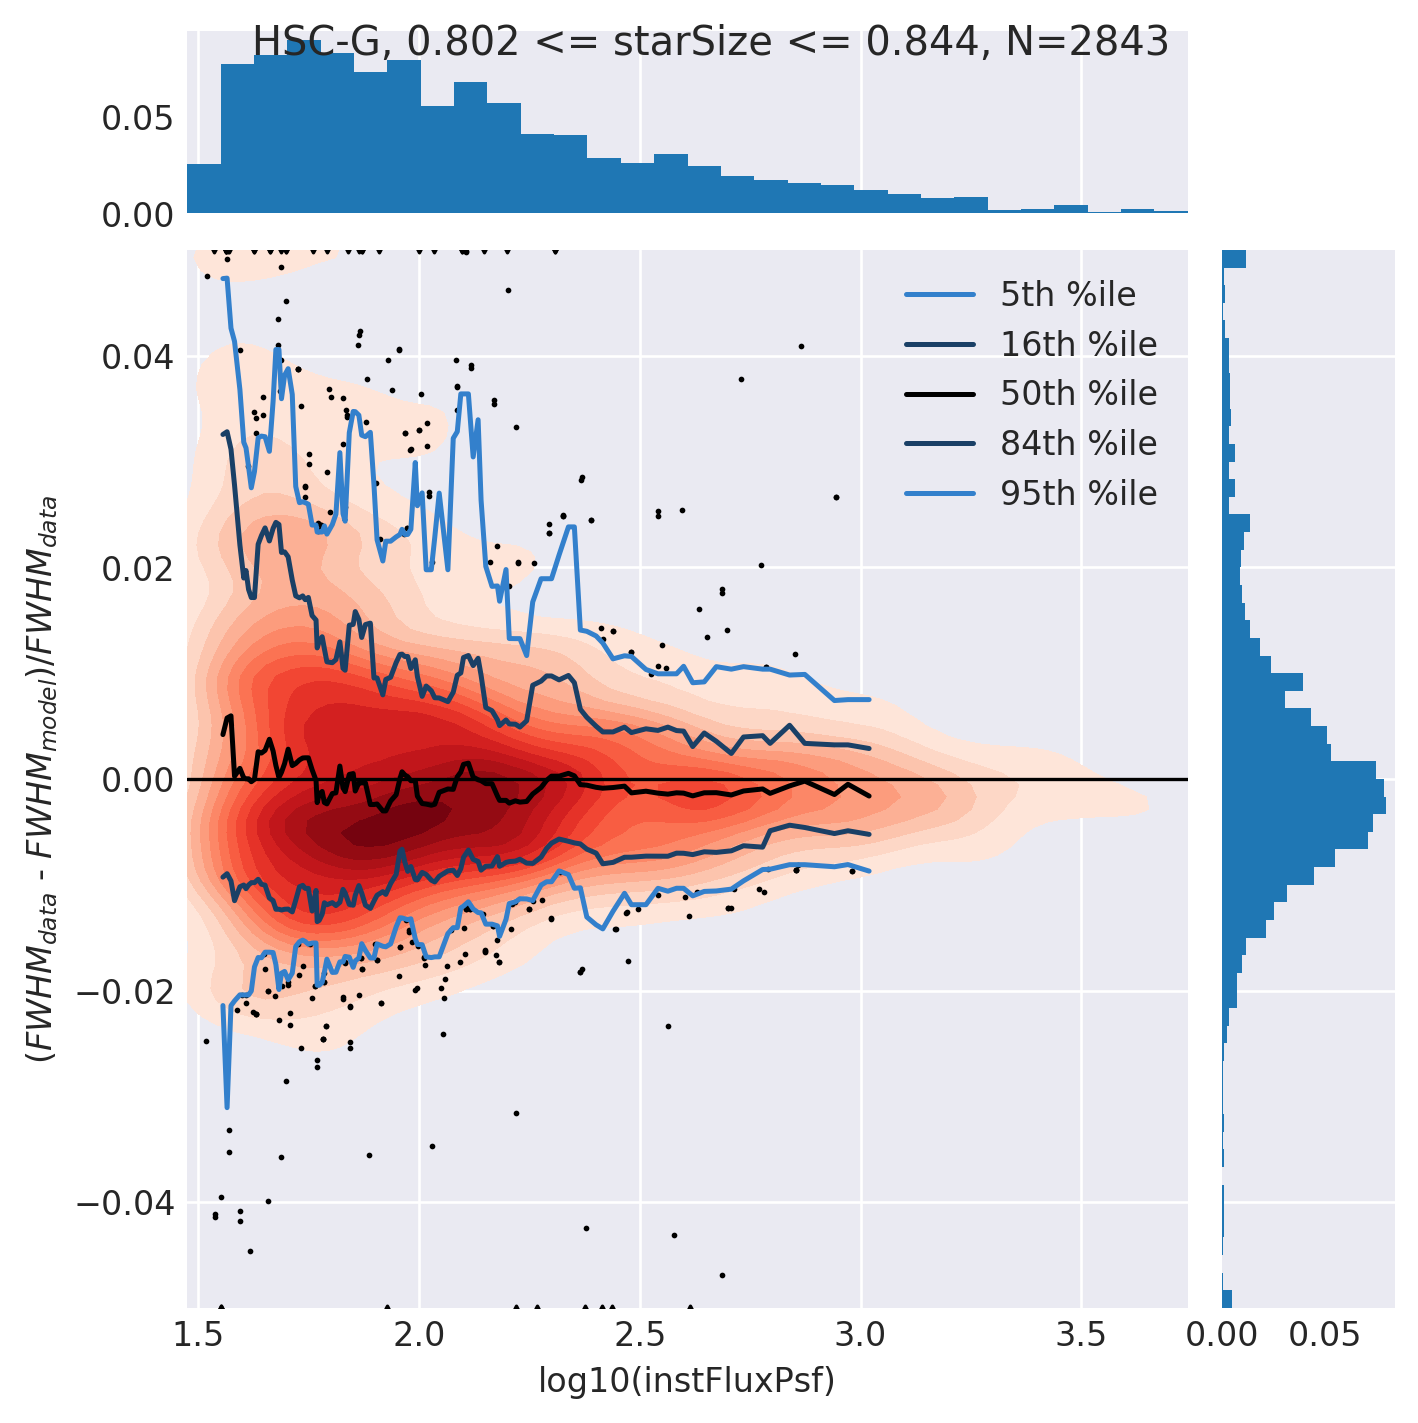

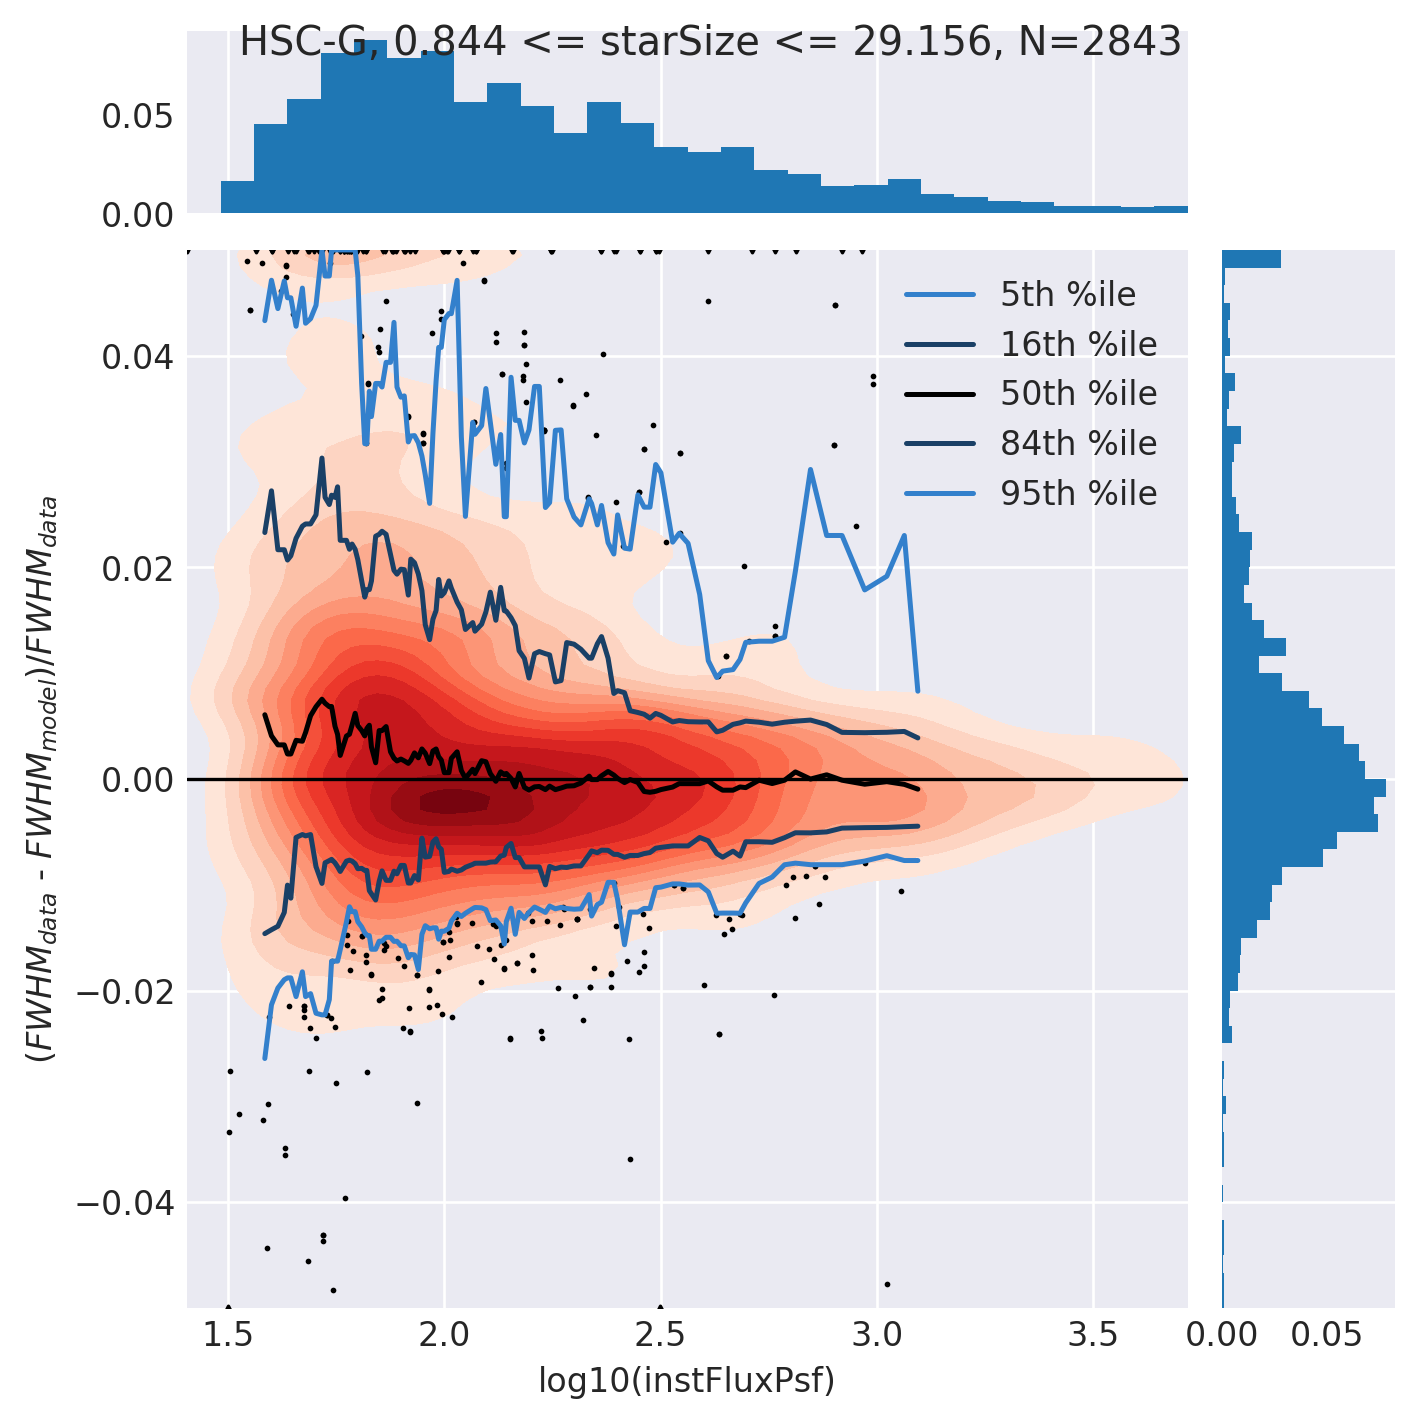

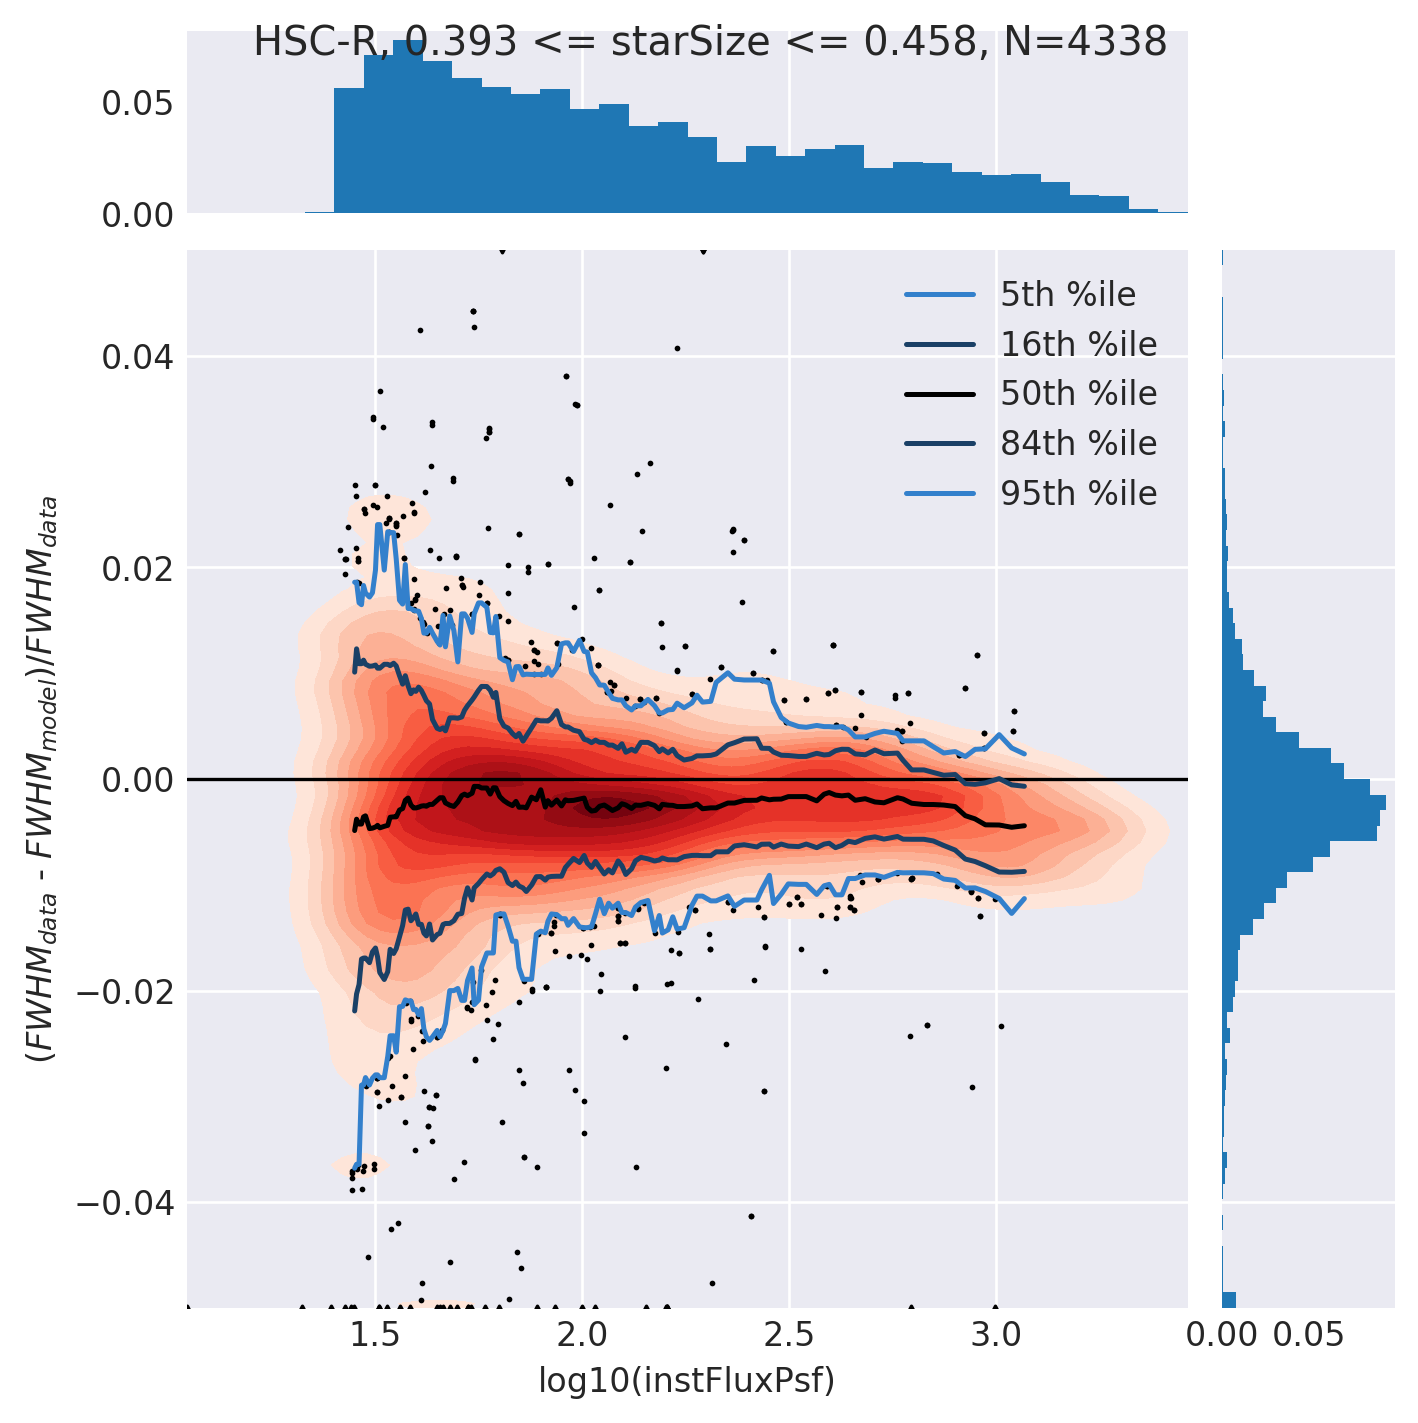

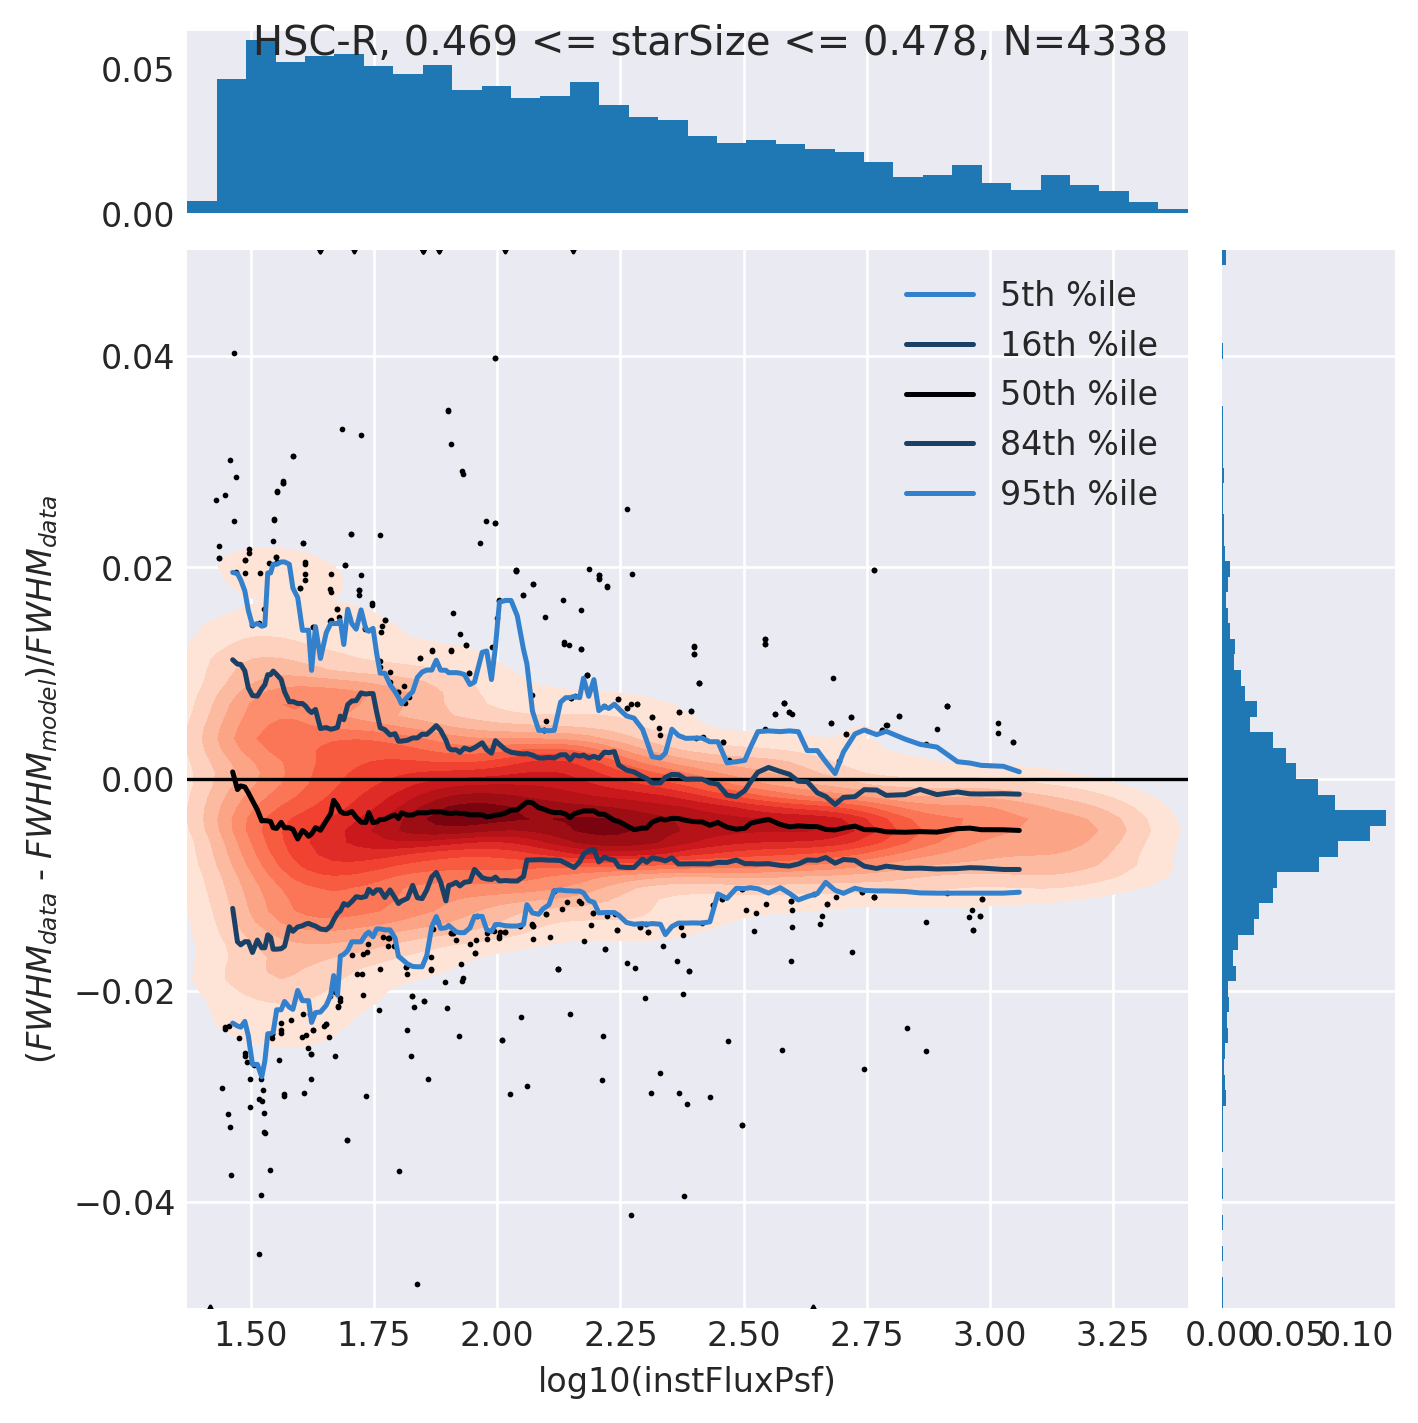

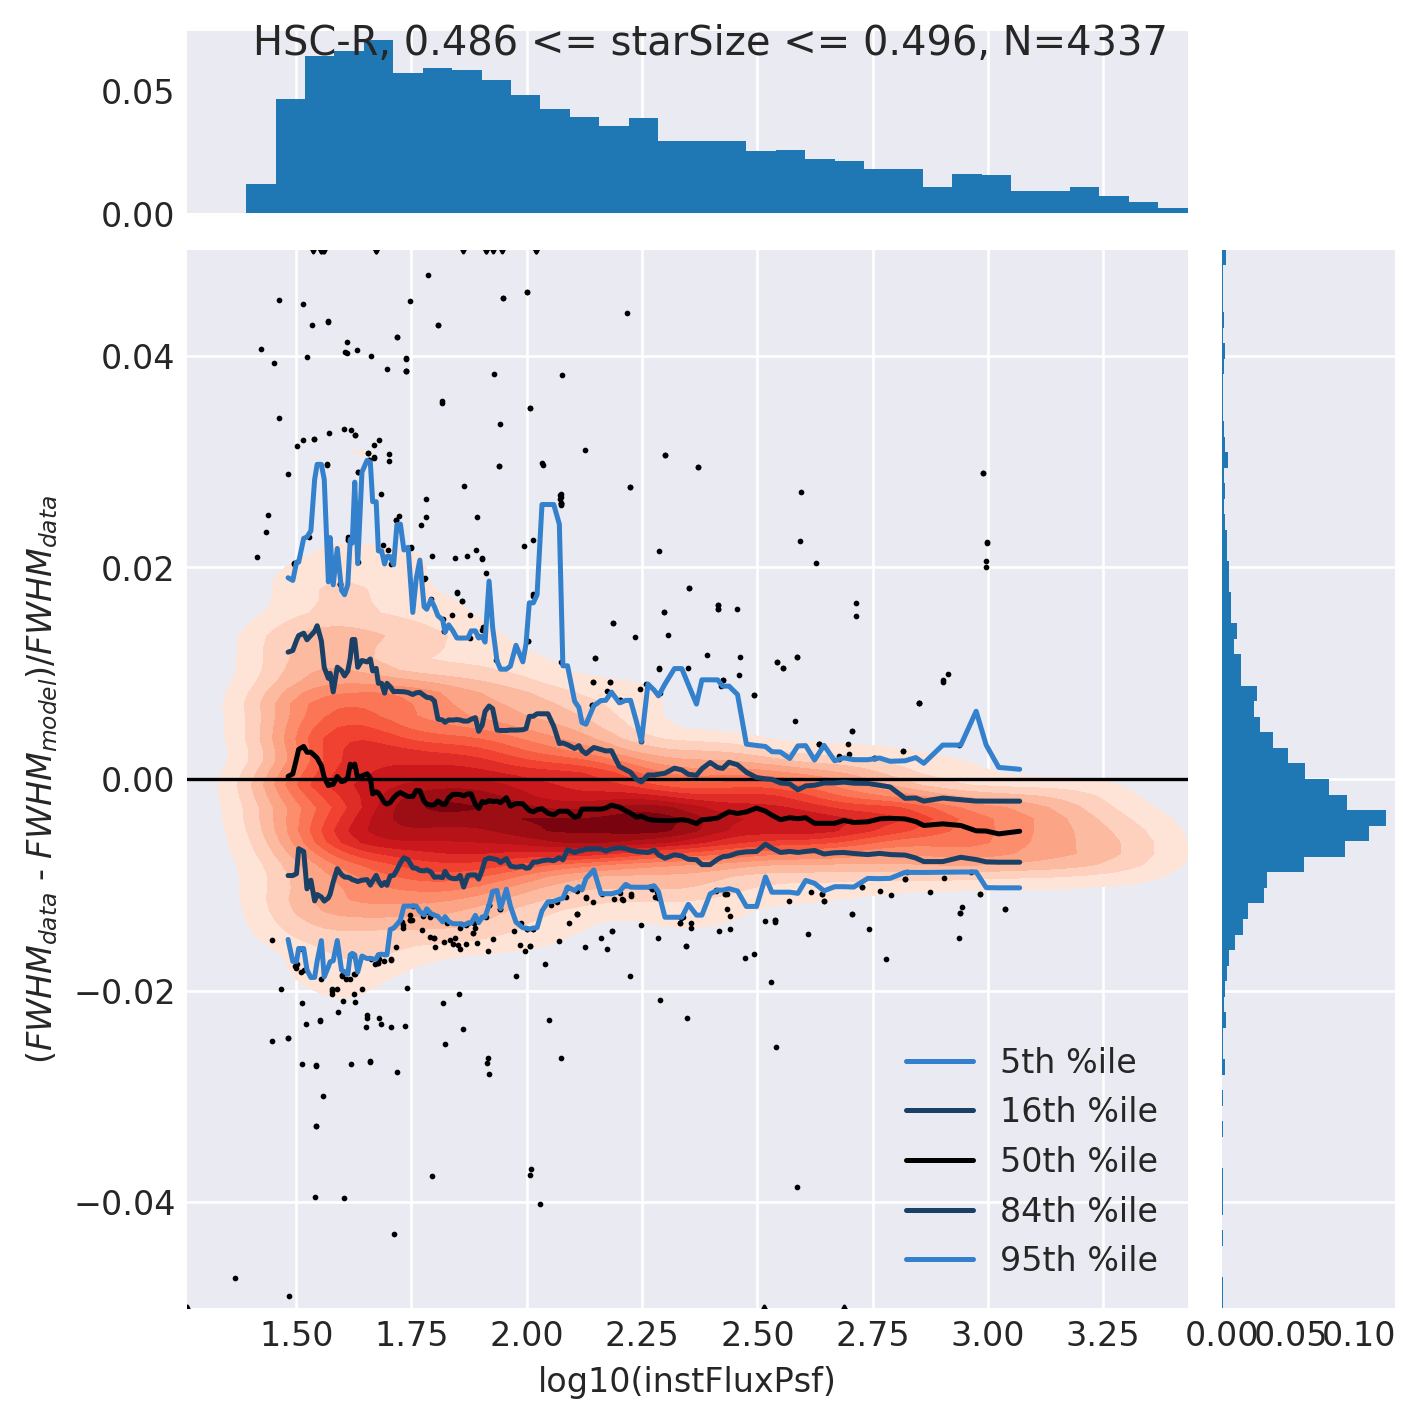

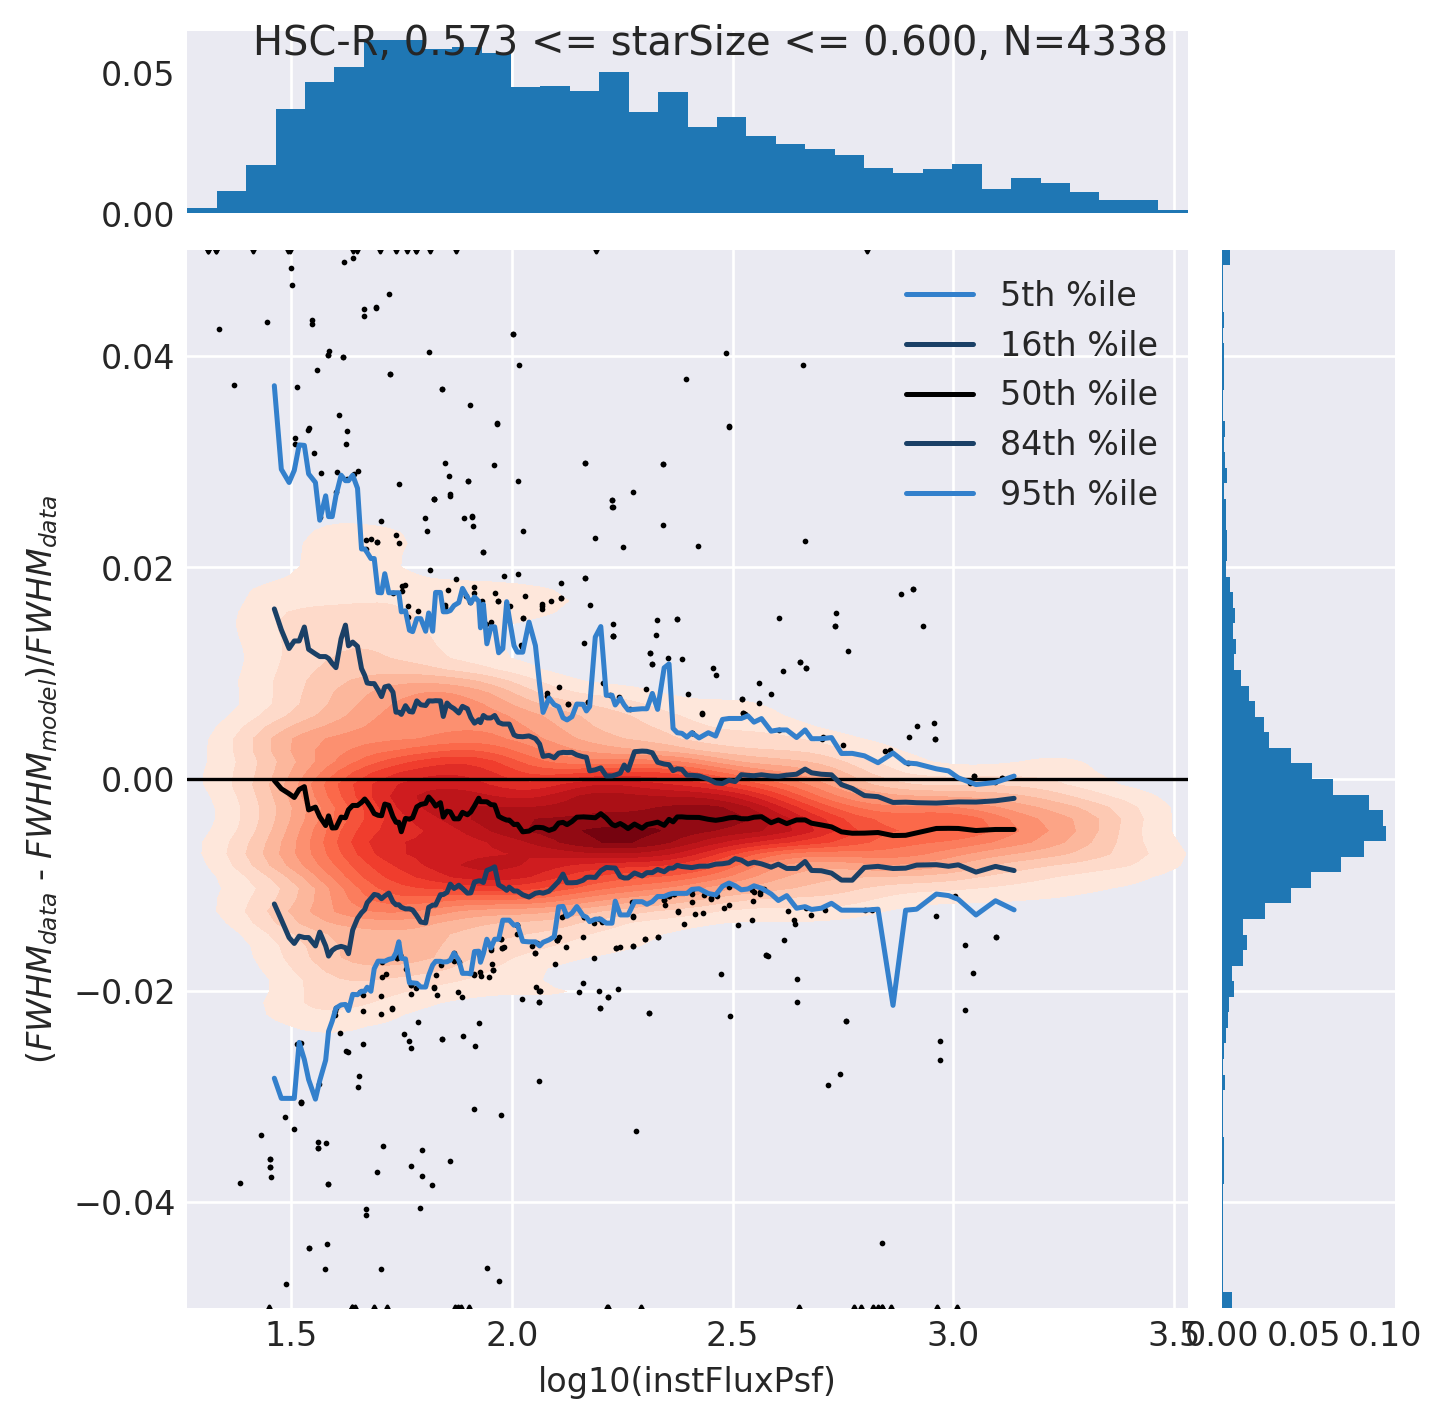

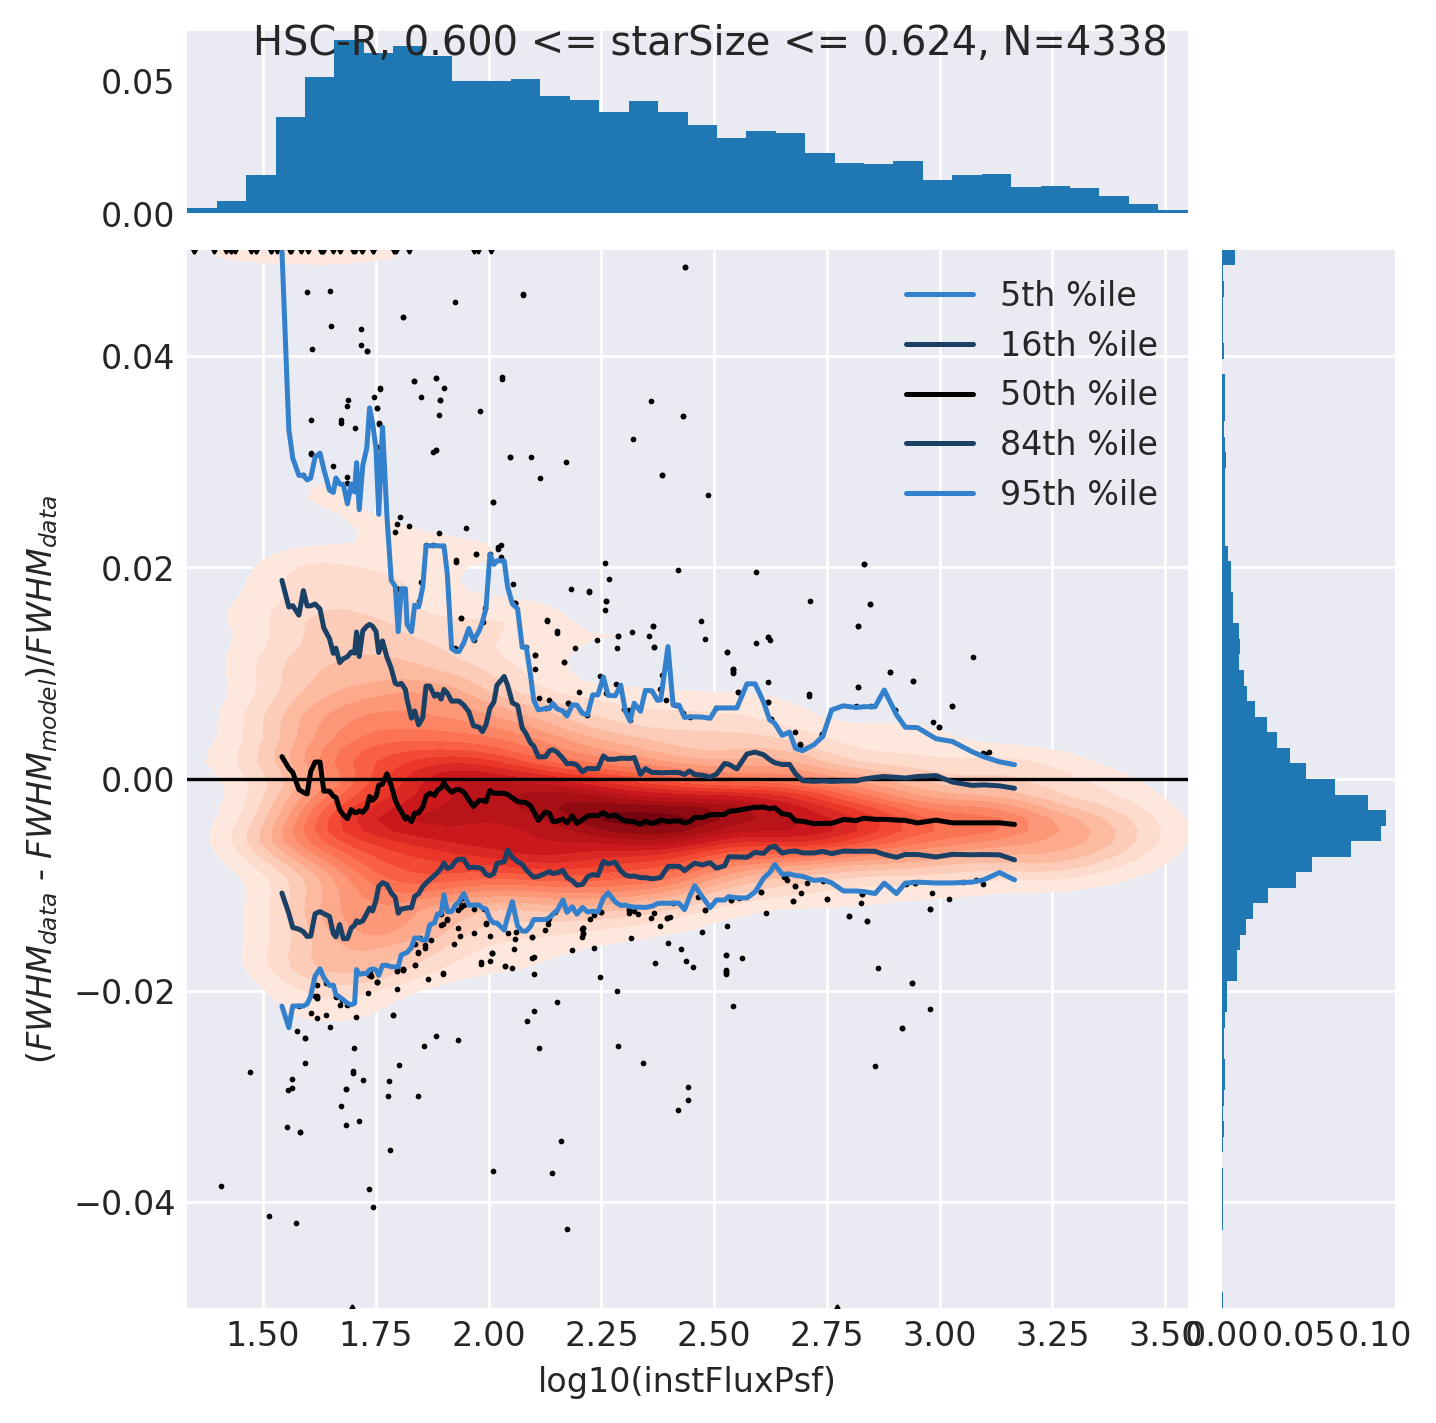

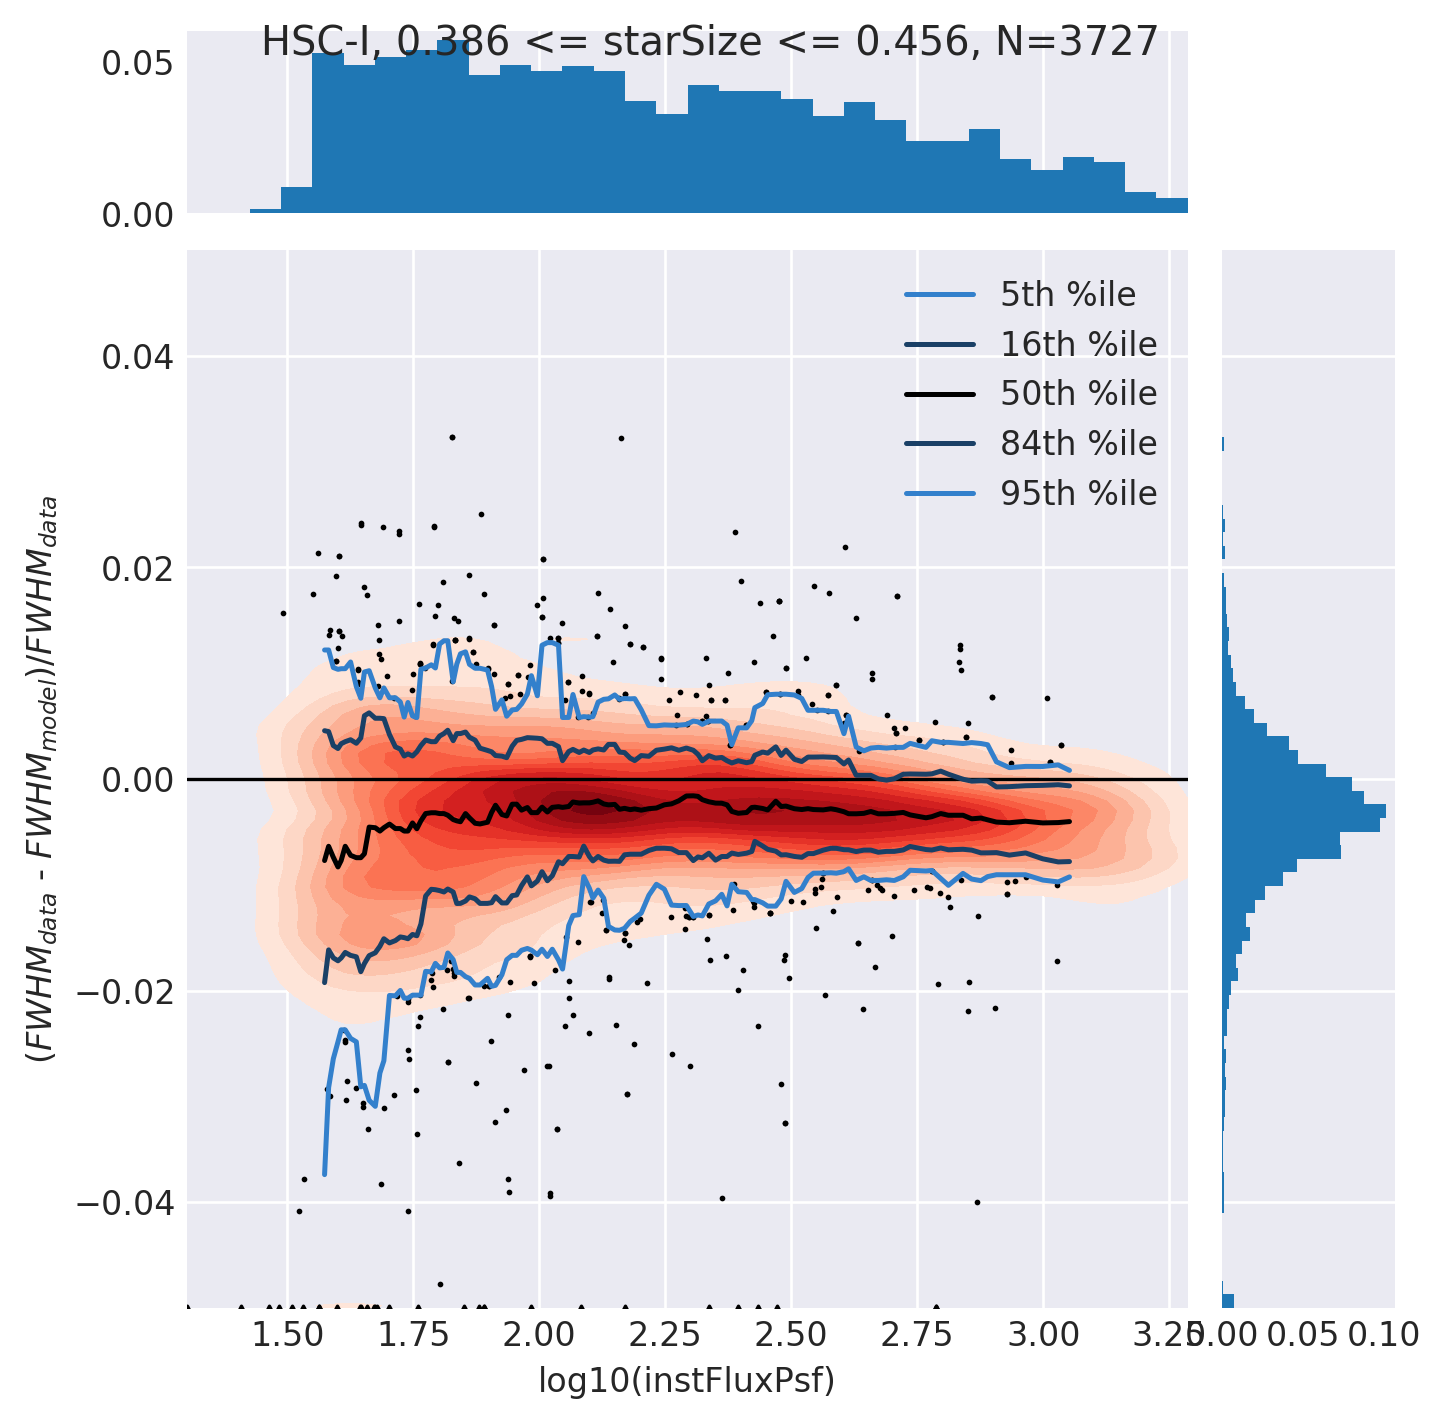

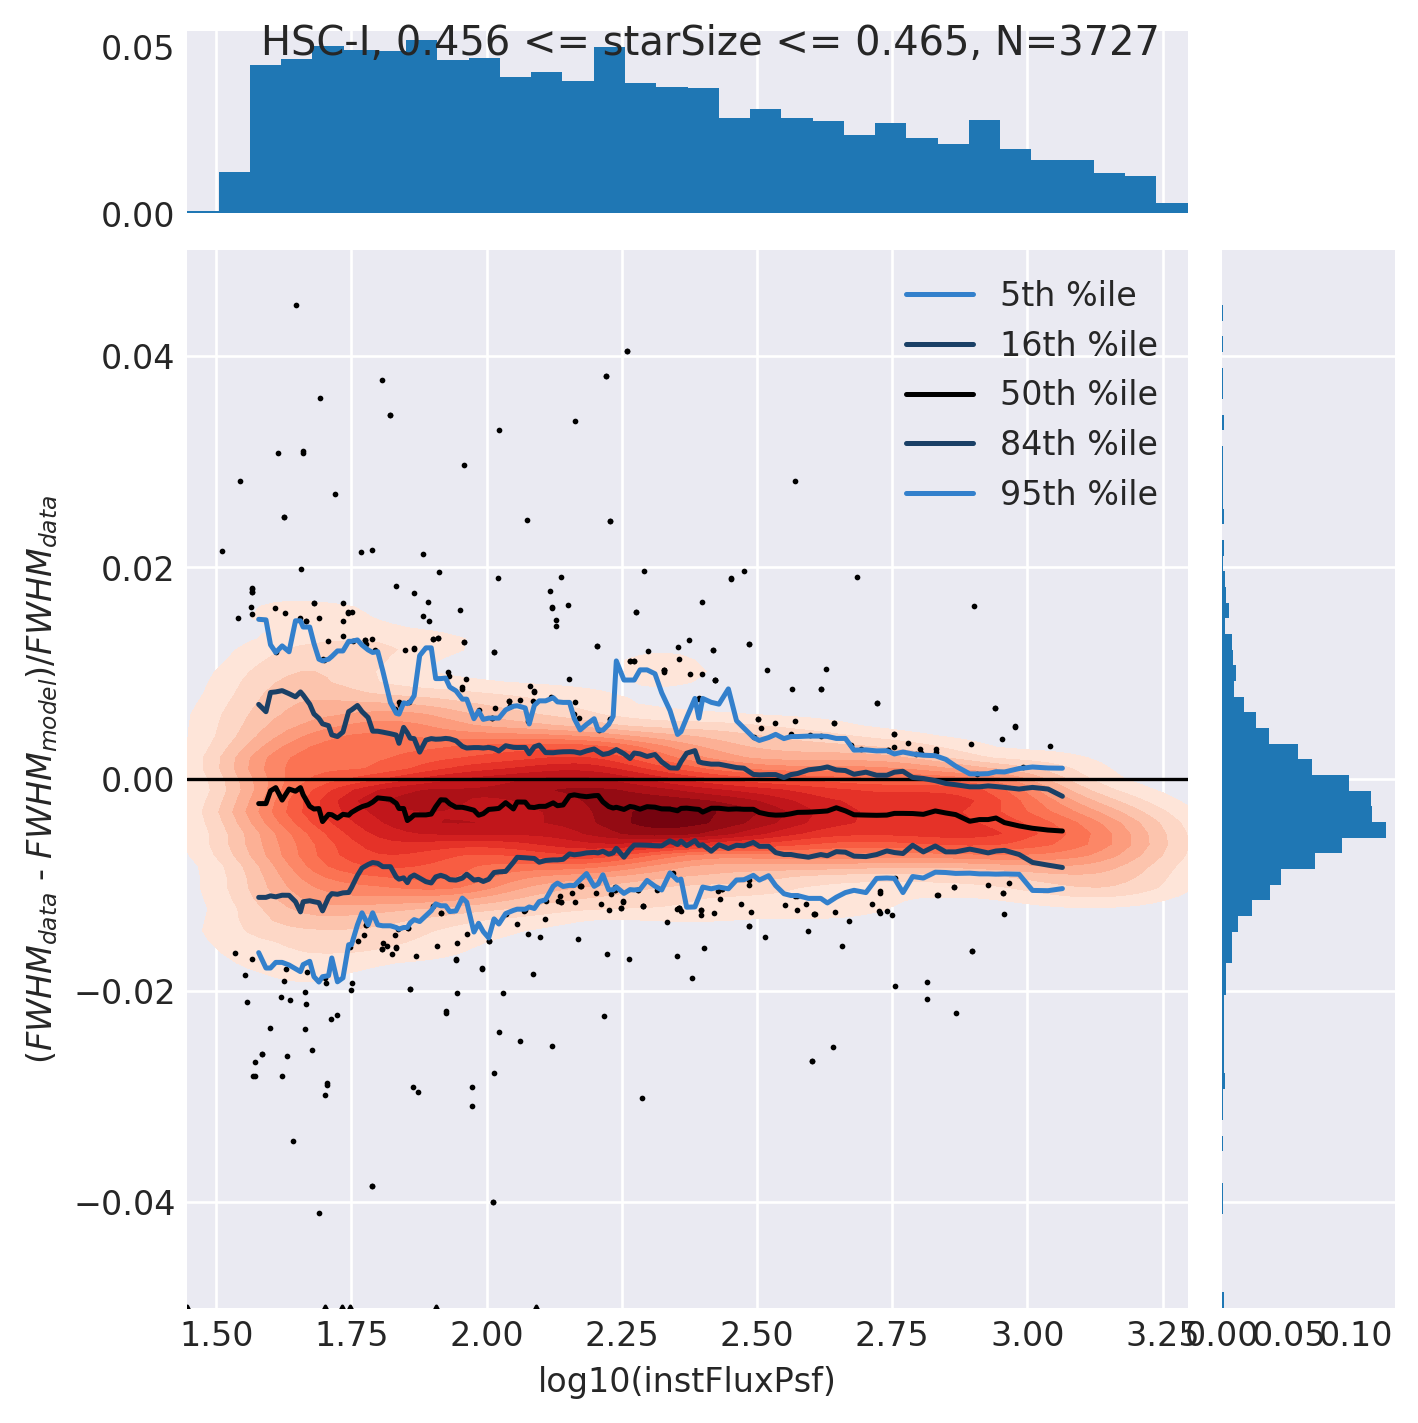

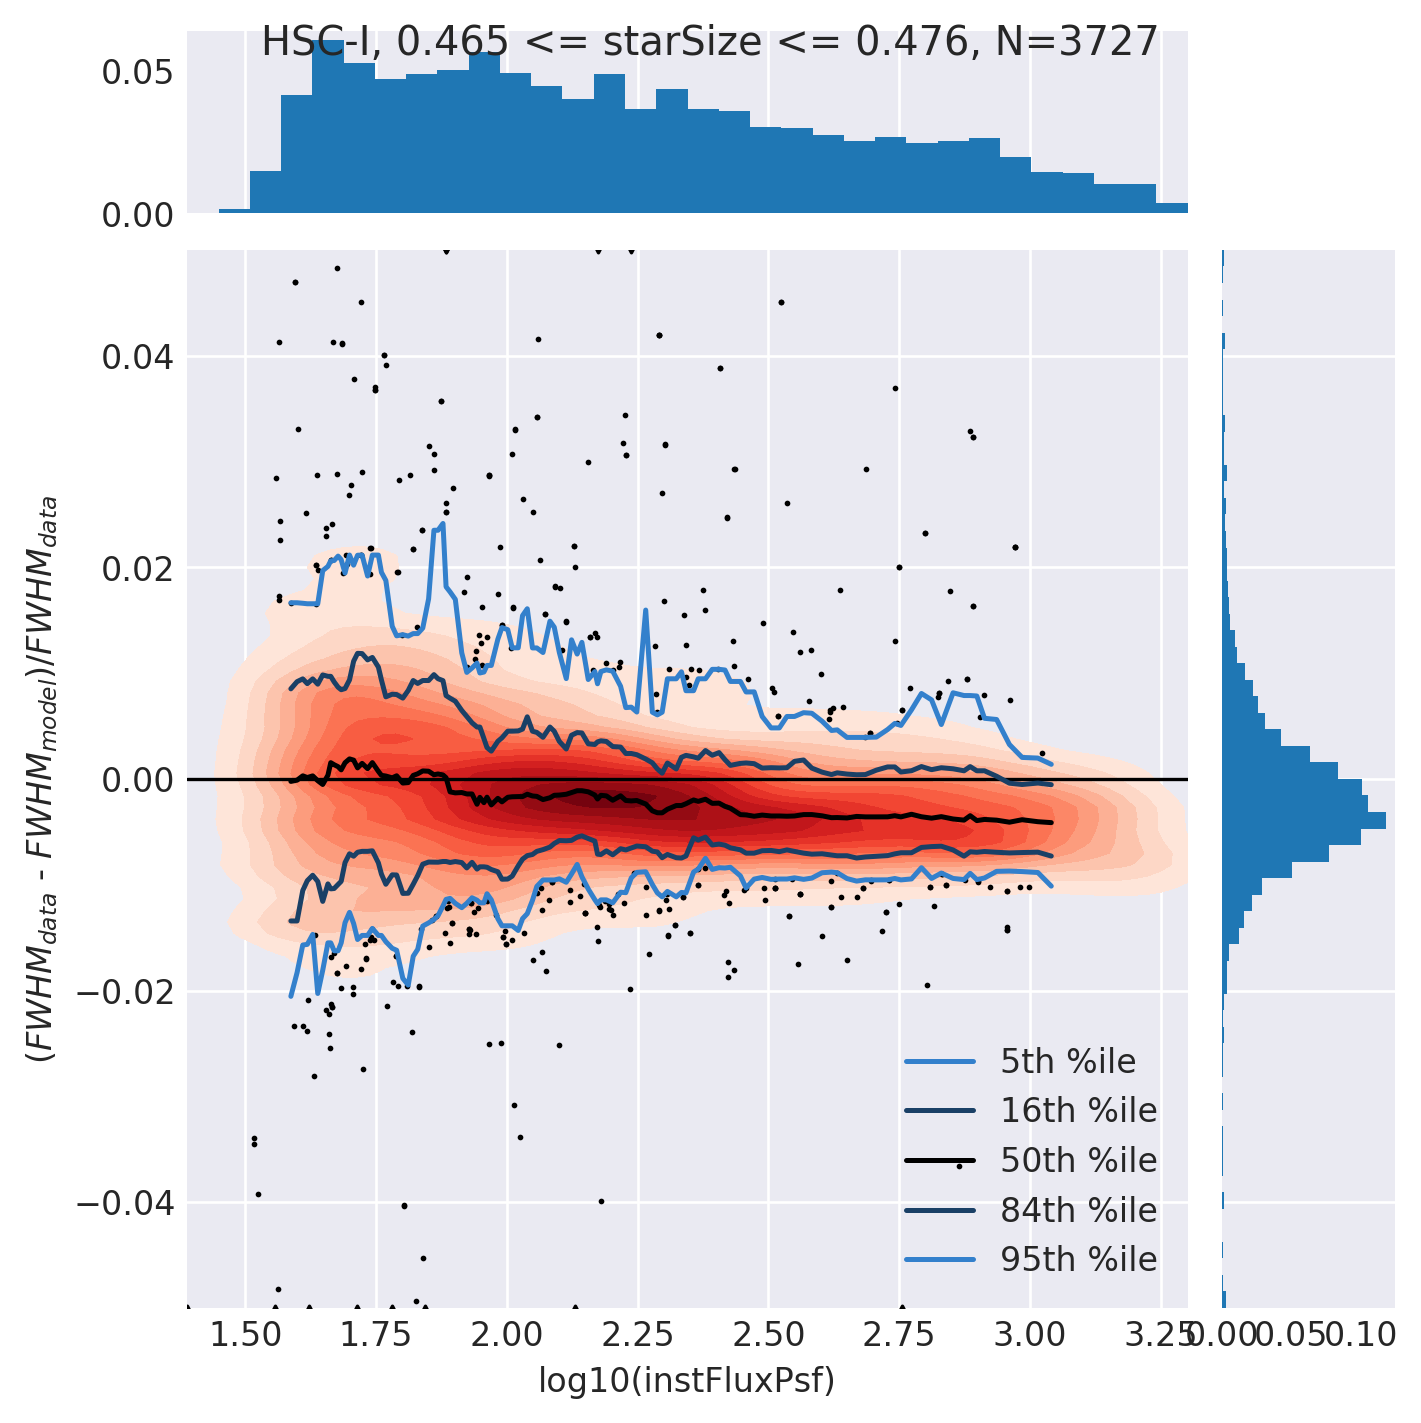

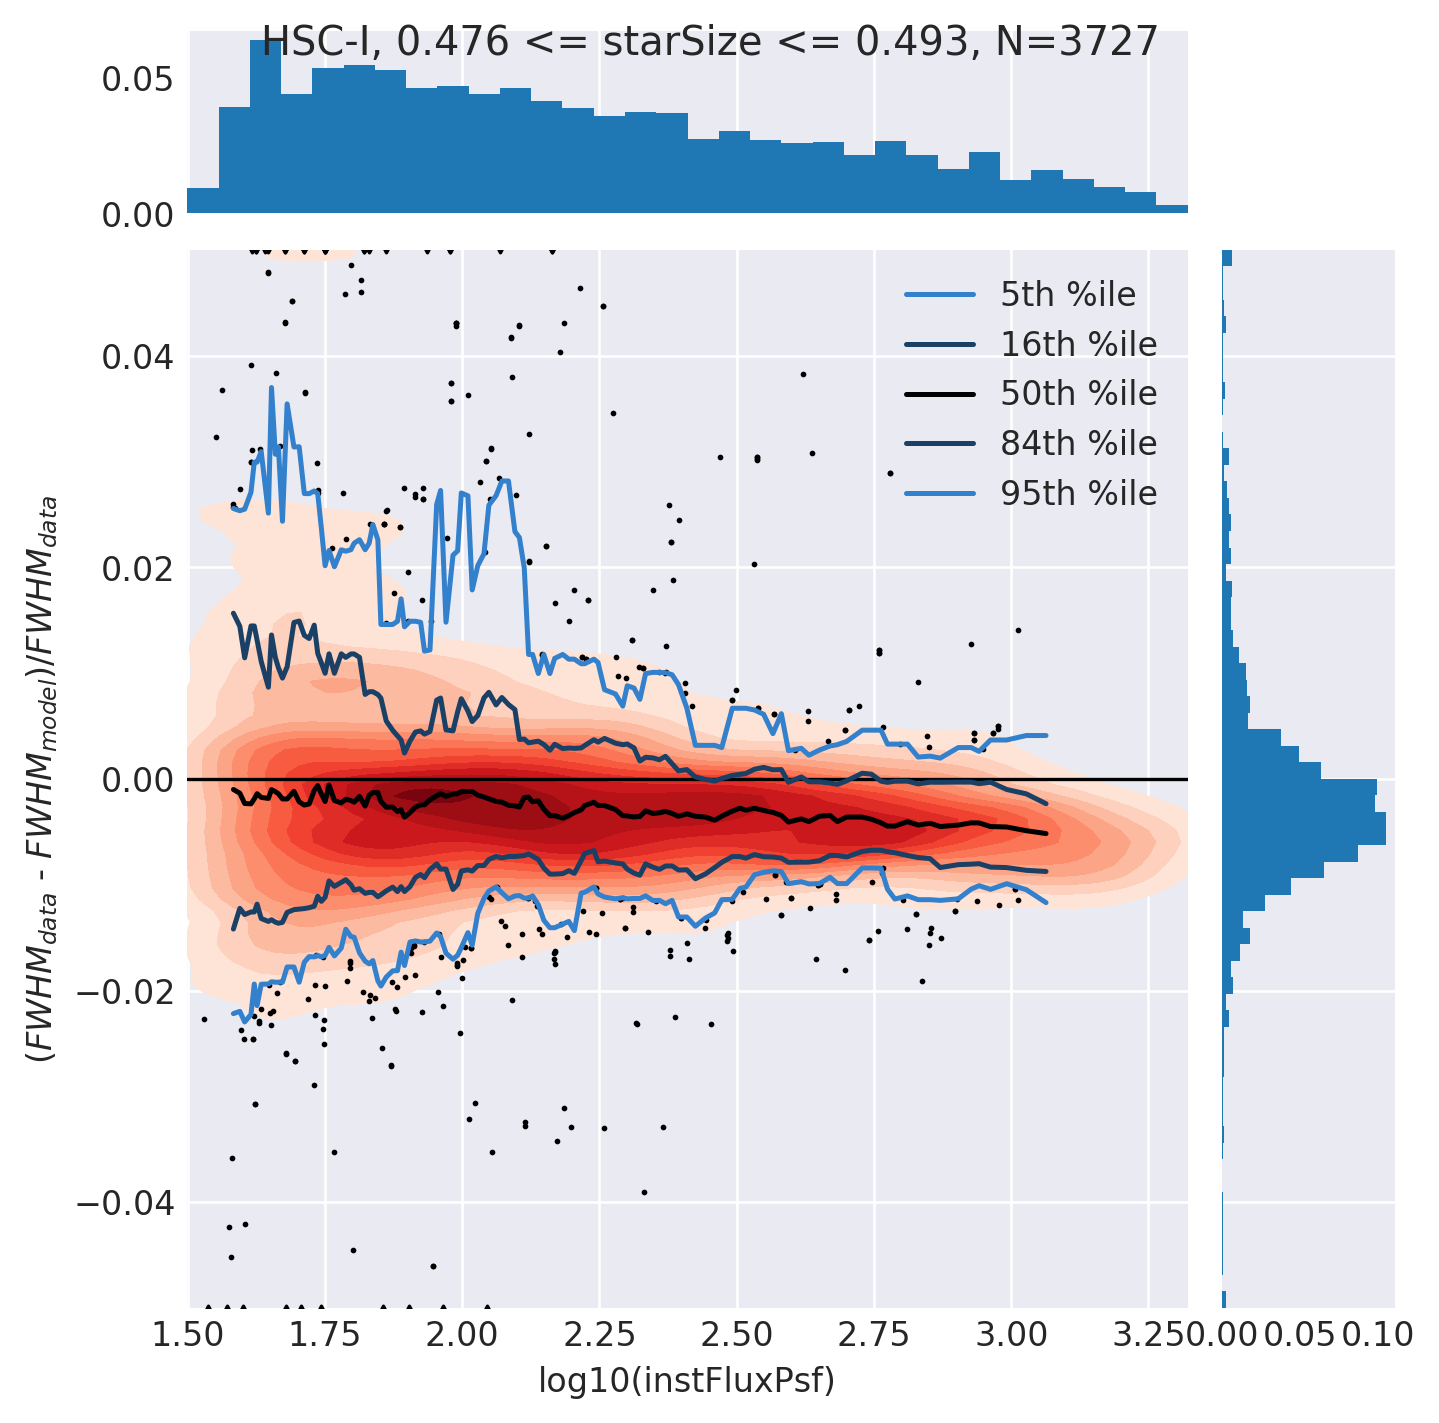

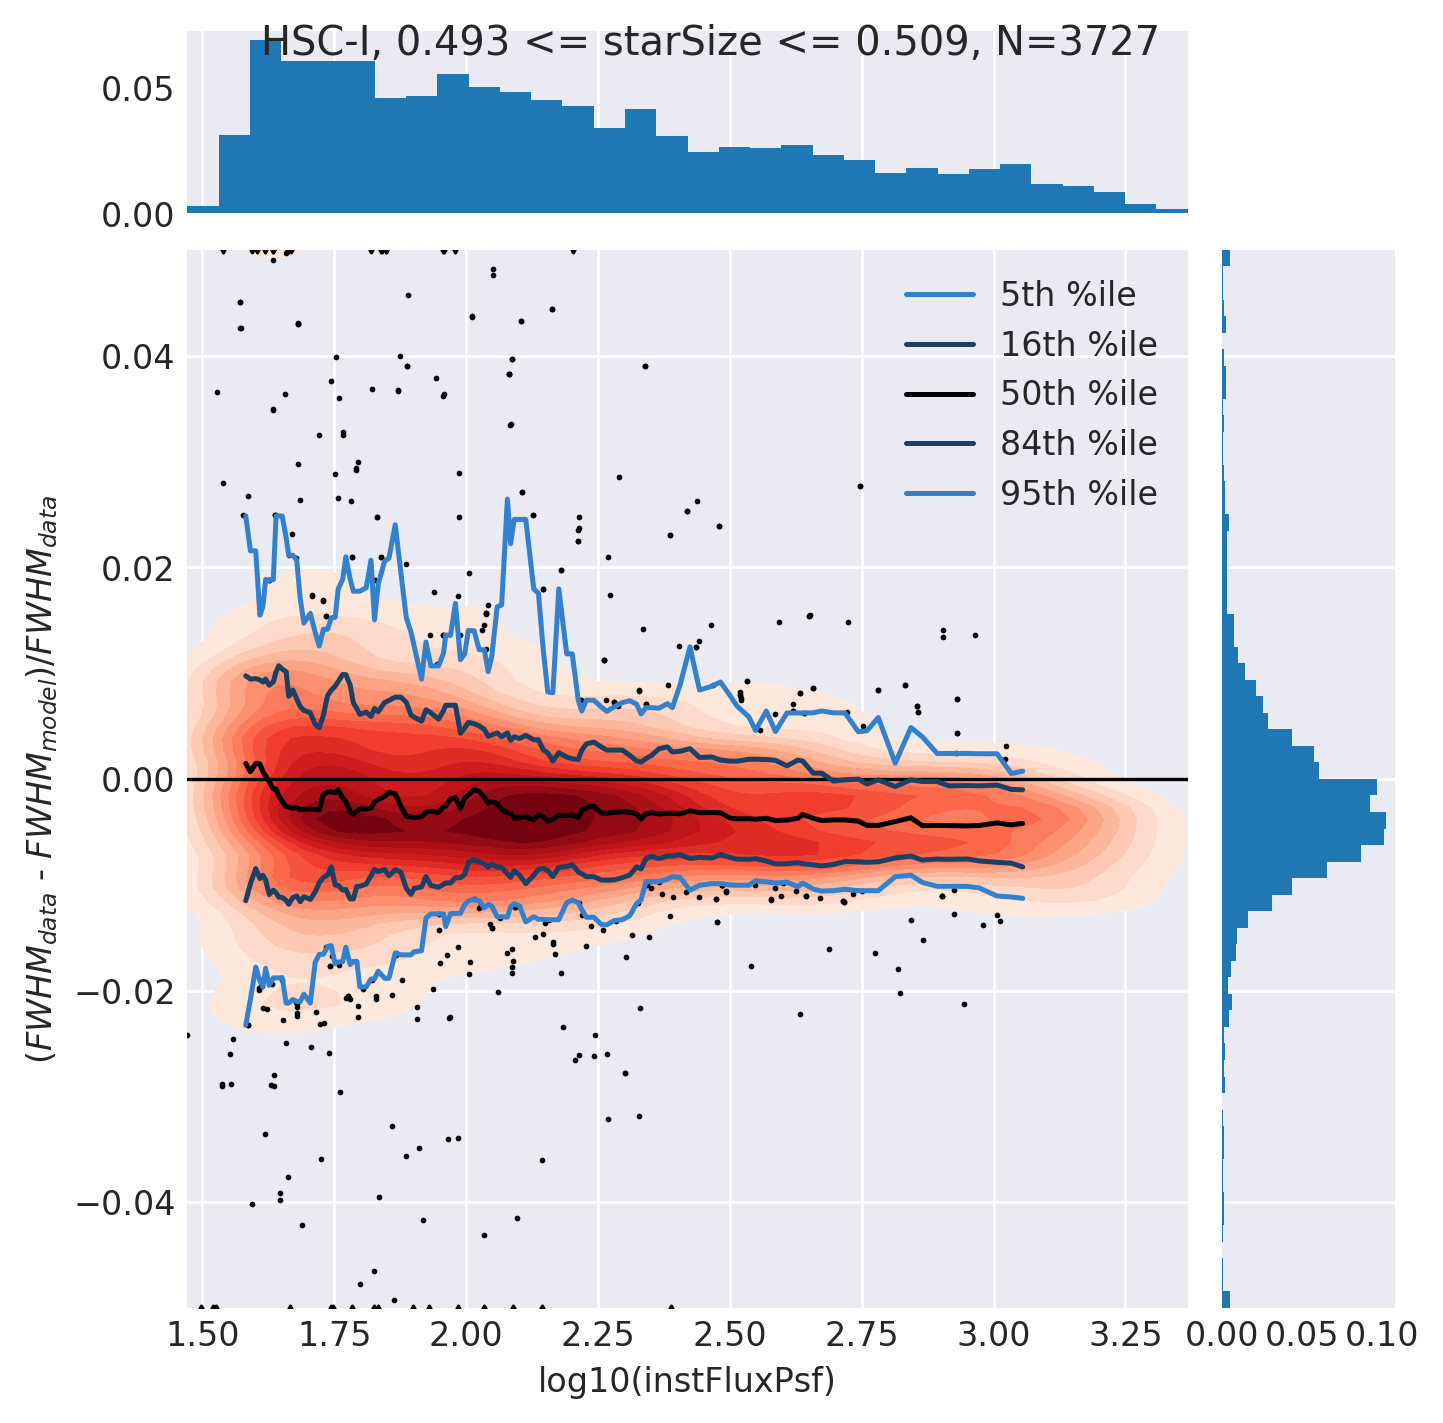

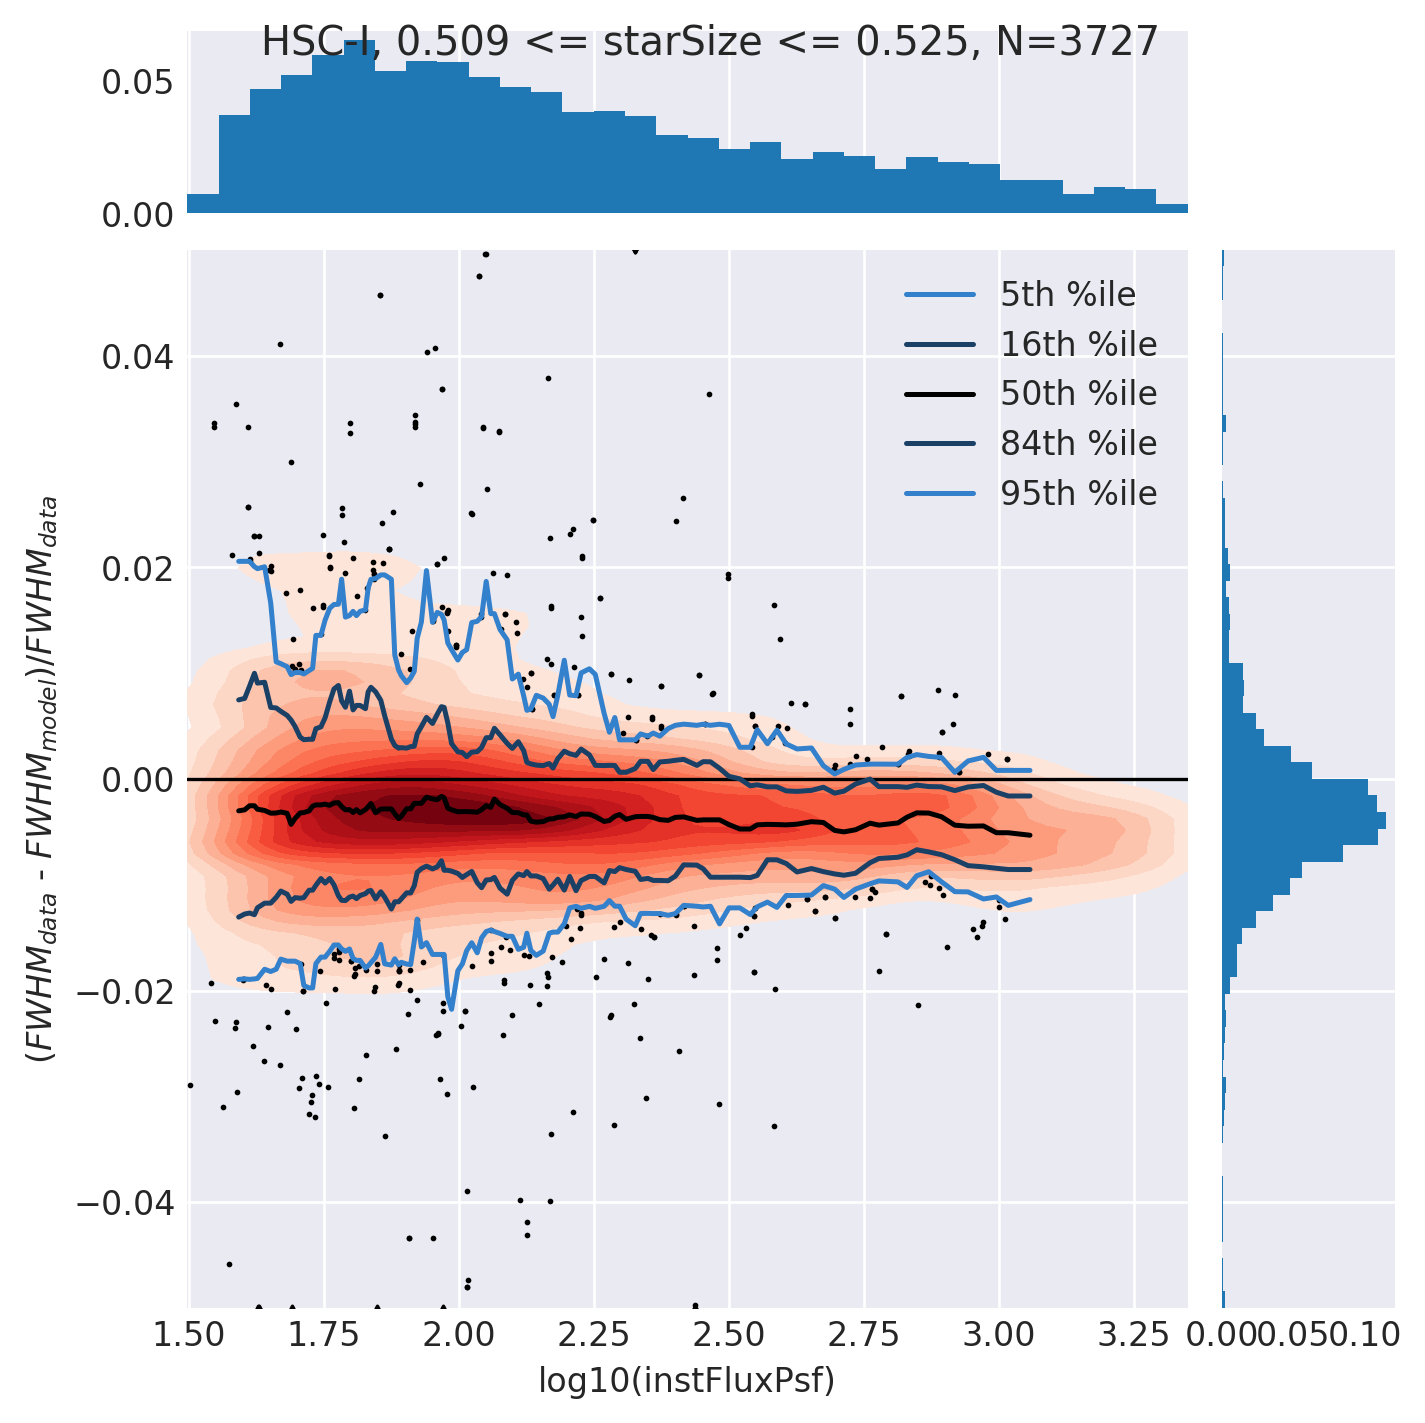

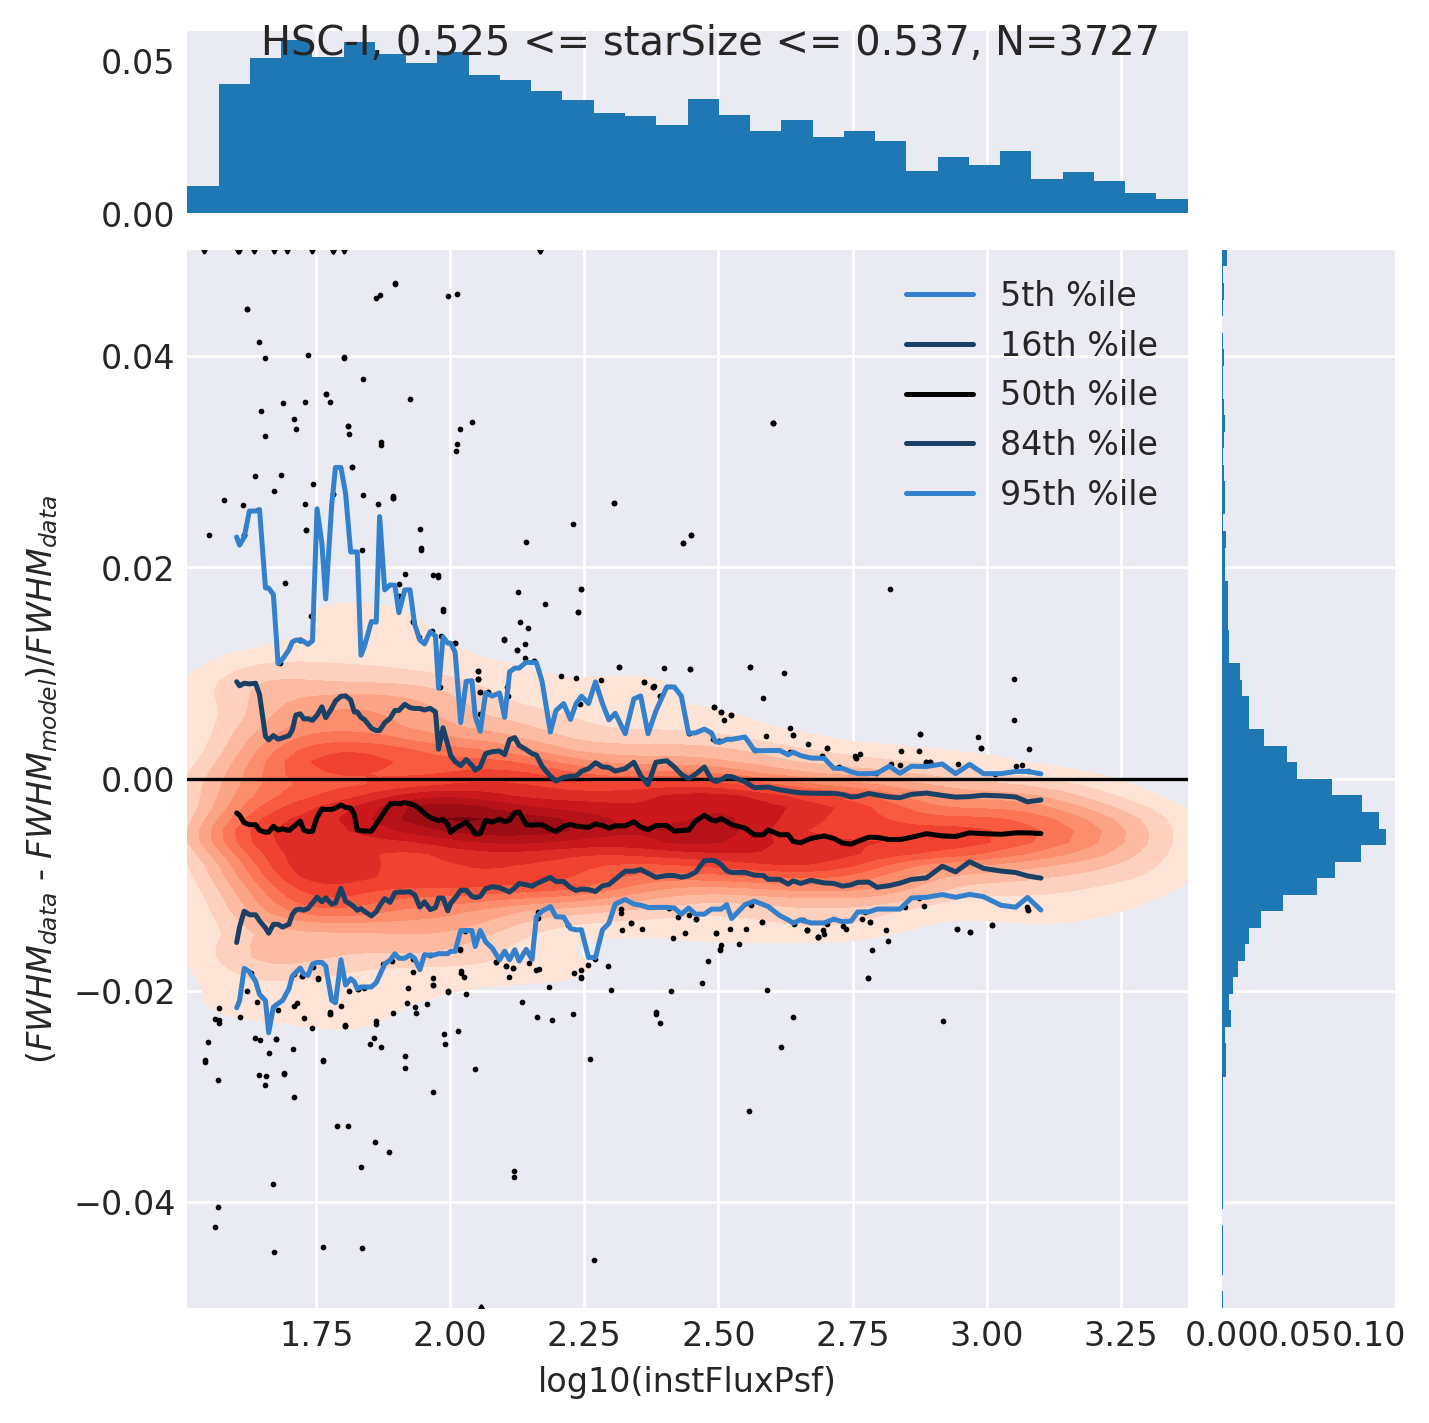

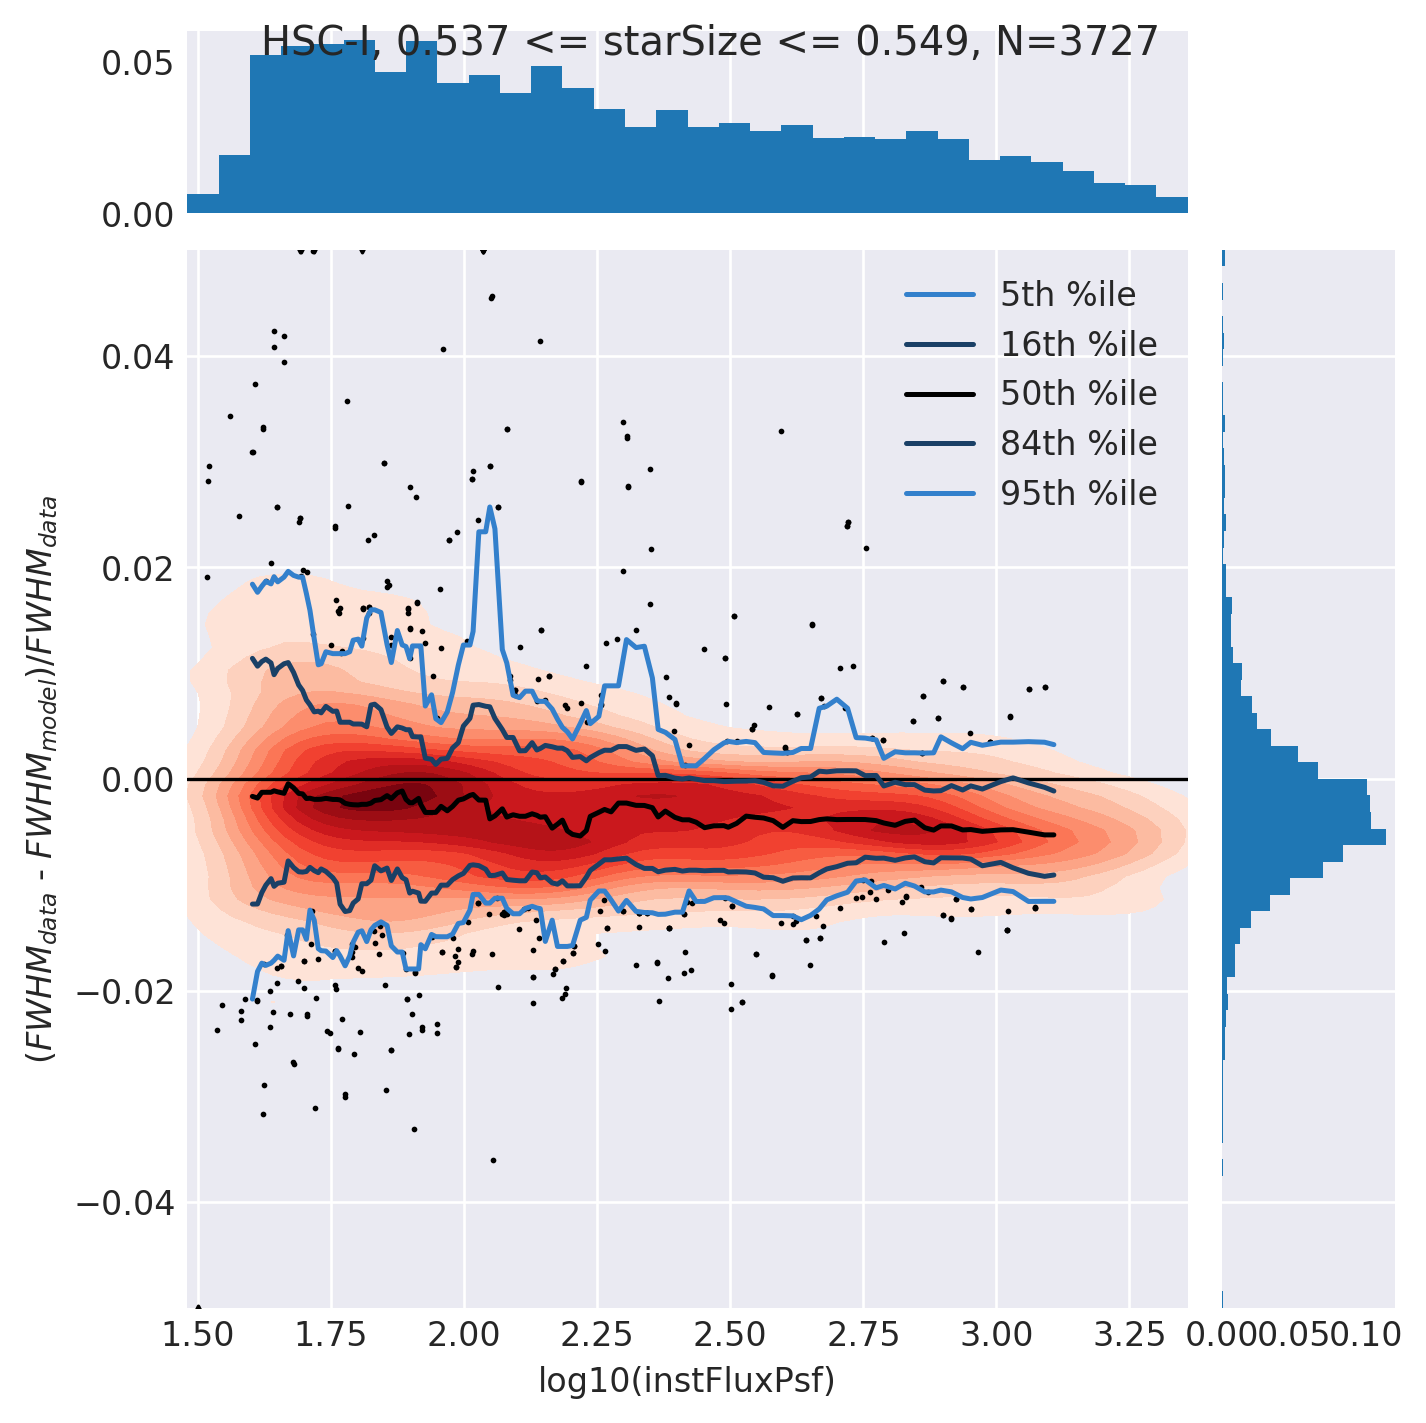

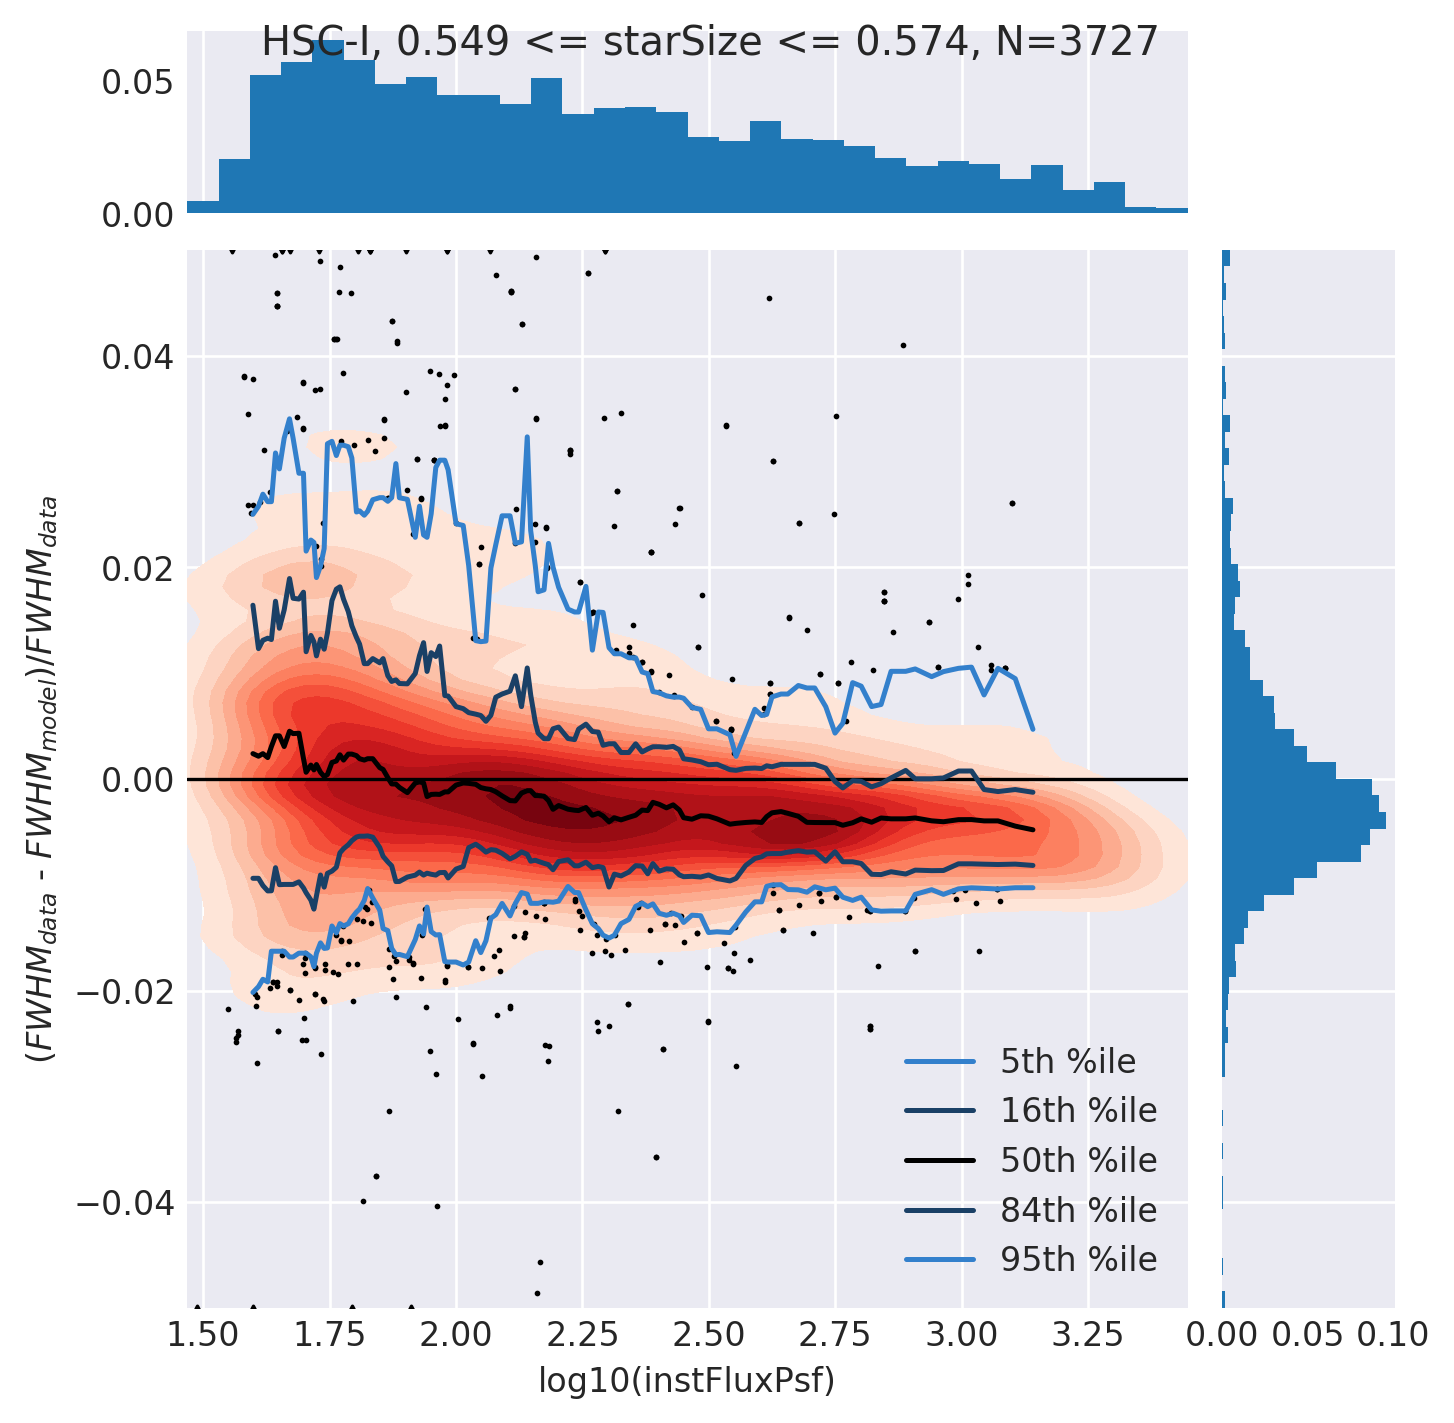

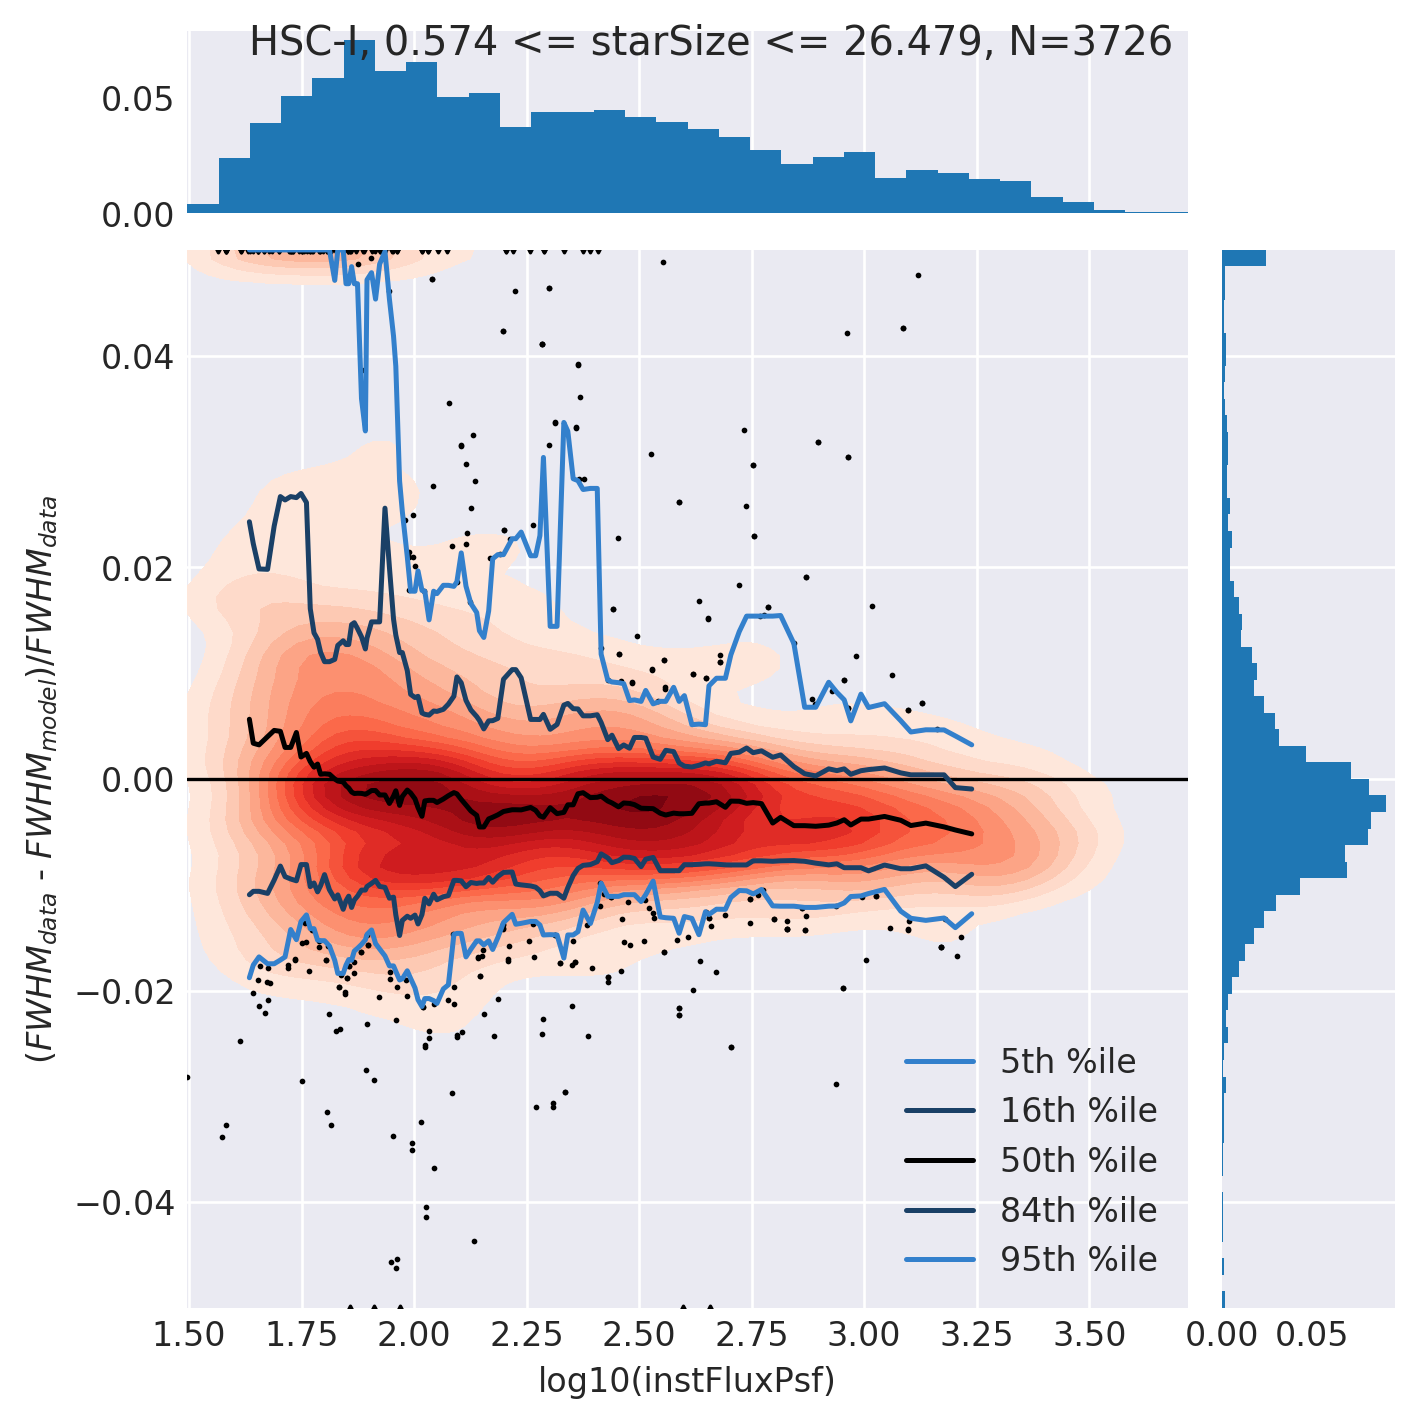

In [33]:
percentiles = [5, 16, 50, 84, 95]
percentilecolours = [(0.2, 0.5, 0.8), (0.1, 0.25, 0.4)]
percentilecolours = percentilecolours + [(0, 0, 0)] + list(reversed(percentilecolours))
binoverlap = 8
limsfrac = (-0.05, 0.05)
tickshist=np.linspace(0, 1, 101)
bandsplot = bands
#bandsplot = ['HSC-G']
doonlyoneplot = False
for band in bandsplot:
    datum = data[band]
    #patches = np.unique(datum['file'])
    patches = []
    sizefrac = (datum['starSize']-datum['modelSize'])/datum['starSize']
    condsizefrac = np.isfinite(sizefrac)*np.isfinite(datum['fluxPsf'])
    sizebins = np.sort(datum['starSize'][condsizefrac])[np.asarray(np.round(np.linspace(0, np.sum(condsizefrac)-1, num=10+1)), dtype=int)]
    for idx in range(len(sizebins)*(not doonlyoneplot)+2*doonlyoneplot-1):
        sizemin, sizemax = sizebins[idx:idx+2]
        cond = condsizefrac*(datum['starSize'] > sizemin)*(datum['starSize'] < sizemax)
        numpoints = np.sum(cond)
        title = '{}, {:.3f} <= starSize <= {:.3f}, N={}'.format(band, sizemin, sizemax, numpoints)
        print(title)
        nbins = np.int(np.ceil(numpoints**(1/3)))
        nedgesover = nbins*binoverlap + 1
        nbinsover = (nbins-1)*binoverlap
        if numpoints > 10:    
            x = np.log10(datum['fluxPsf'][cond])
            y = sizefrac[cond]
            # Set the outliers to the limits and store them
            # TODO: Set the point style for outliers as triangles
            isfraclo = y < limsfrac[0]
            isfrachi = y > limsfrac[1]
            y[isfraclo] = limsfrac[0]
            y[isfrachi] = limsfrac[1]
            # Make a joint grid, plot a KDE and leave the marginal plots for later
            p = sns.JointGrid(x=x, y=y, ylim=limsfrac, xlim=(np.min(x), np.max(x)))
            p.plot_joint(sns.kdeplot, cmap="Reds", shade=True, shade_lowest=False, n_levels = np.int(np.ceil(numpoints**(1/3))))
            # Setup bin edges to have overlapping bins for running percentiles
            binedges = np.sort(x)[np.asarray(np.round(np.linspace(0, len(x)-1, num=nedgesover)), dtype=int)]
            plt.plot(binedges[[0, -1]], [0, 0], 'k-', linewidth=1, label='')
            plt.xlabel('log10(instFluxPsf)')
            plt.ylabel(r'($FWHM_{data}$ - $FWHM_{model}$)/$FWHM_{data}$')
            xbins = np.zeros(nbinsover)
            ybins = [np.zeros(nbinsover) for _ in range(len(percentiles))]
            # Get running percentiles
            for idxbin in range(nbinsover):
                xlower, xupper = binedges[[idxbin,idxbin+binoverlap-1]]
                condbin = (x >= xlower)*(x <= xupper)
                xbins[idxbin] = np.median(x[condbin])
                ybin = np.sort(y[condbin])
                for idxper, percentile in enumerate(percentiles):
                    ybins[idxper][idxbin] = np.percentile(ybin, percentile)
            for yper, pc, colpc in zip(ybins, percentiles, percentilecolours):
                plt.plot(xbins, yper, linestyle='-', color=colpc, linewidth=1.5, label=str(pc) + 'th %ile')
            plt.legend()
            xlowerp = binedges[0]
            idxxupper = np.int(np.ceil(binoverlap/2))
            xupperp = binedges[idxxupper]
            # Plot outliers, with points outside of the plot boundaries as triangles
            # Not really neccessary but more explicit.
            # TODO: Color code outliers by y-value?
            for idxbin in range(nbinsover):
                condbin = (x >= xlowerp)*(x <= xupperp)
                xcond = x[condbin]
                ycond = y[condbin]
                for upper, condoutlier in enumerate([ycond <= ybins[0][idxbin], ycond >= ybins[-1][idxbin]]):
                    noutliers = np.sum(condoutlier)
                    if noutliers > 0:
                        if upper:
                            condy2 = isfrachi[condbin]
                            marker = 'v'
                        else:
                            condy2 = isfraclo[condbin]
                            marker = '^'
                        #print(np.sum(condbin), np.sum(condoutlier), np.sum(condy2), np.sum(condoutlier*condy2), np.sum(condoutlier*(1-condy2)))
                        for condplot, markercond in [(condoutlier*condy2, marker), (condoutlier*(~condy2), '.')]:
                            if np.sum(condplot) > 0:
                                plt.scatter(xcond[condplot], ycond[condplot], s=2, marker=markercond, color='k')
                        #plt.scatter(xcond[condoutlier], ycond[condoutlier], s=2, marker=markercond, color='k')
                xlowerp = xupperp
                if idxbin == (nbinsover-2):
                    idxxupper = -1
                else:
                    idxxupper += 1
                    xupperp = binedges[idxxupper]
            p.ax_marg_x.hist(x, bins=nbins*2, weights=np.repeat(1.0/len(x), len(x)))
            plt.setp(p.ax_marg_x.get_yticklabels(), visible=True)
            p.ax_marg_x.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.05))
            p.ax_marg_y.hist(y, orientation='horizontal', bins=nbins*4, weights=np.repeat(1.0/len(y), len(y)))
            plt.setp(p.ax_marg_y.get_xticklabels(), visible=True)
            p.ax_marg_y.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.05))
            p.fig.suptitle(title)
    for patch in patches:
        cond = (datum['file'] == patch)*condsizefrac
        grid = sns.jointplot(np.log10(datum['fluxPsf'][cond]), sizefrac[cond], ylim=[-0.1,0.1],
                             stat_func=None, size=4, s=1, marginal_kws={'bins':30})
        grid.fig.suptitle(band)
plt.show()